# Imports

In [65]:
import os
import errno
from importlib import reload
import pickle 
from pprint import pprint
from itertools import product

In [66]:
import pandas as pd
from scipy import stats
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
# just so saved plots aren't also shown
matplotlib.use('Agg')
%matplotlib inline
import seaborn as sns

import pymc3 as pm
import theano as T
import theano.tensor as tt
import arviz as az
import xarray as xr

In [67]:
# packages versions
print(
    '\n'.join(
        f'{m.__name__}=={m.__version__}' 
        for m in globals().values() 
        if getattr(m, '__version__', None)
    )
)

pandas==1.2.3
scipy==1.5.3
numpy==1.20.3
matplotlib==3.4.3
seaborn==0.11.2
pymc3==3.11.2
theano==1.1.2
arviz==0.11.4
xarray==0.21.1


# Useful functions

## Data & traces: loading / saving

In [68]:
def save_trace(name, trace):
    try:
        os.makedirs(f'models_traces/{name}')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
        
    trace.to_netcdf(f'models_traces/{name}/trace.nc')
                    

def load_model_and_trace(name):
    returndict = dict()
    returndict['trace'] = az.from_netcdf(f'models_traces/{name}/trace.nc')
    
    # TODO: I am ignoring models for now because
    # loading them with pickle causes an error.
    # They can be redefined quite simply directly in the code as needed.
    # But leave it open for loading model in the future
    
    return returndict

In [69]:
def get_and_clean_data(pathdata='data_raw.csv'):
    """
    Get the raw data and cleans it. 
    Returns various useful objects (see below).
    
    Returns
    -------
    tuple
        raw_data: pd df 
            Dataframe containing the full data 
        data: pd df 
            Dataframe containing the data without 
            incomplete and literally false responses
        possible_observations: 2-d array
            Array with the possible unique observations
            that participants actually saw in the experiment.
            Contains the number of correct answers
            of each student in each observation.
            Dimensions: (observations, students)
        possible_utterances: 2-d array
            Array with the possible unique utterances
            that the participants could produce in the experiment.
            Each utterance has three components: 
            (outer quant, inner quant, adjective)
            Dimensions: (utterances, utterance components)
    """
    
    raw_data = pd.read_csv(pathdata)
    
    data = raw_data[[
        'condition', 'response', 'row_number', 'trial_name', 'prolific_id'
    ]]
    
    data = (
        data[raw_data['trial_name']=='main_trials']
        .reset_index(drop=True)
    )
    
    print(
        'a total of ' +
        str(len(data[raw_data['trial_name'] != 'main_trials'])) +
        ' of the raw datapoints are test trials. ' +
        'This leaves 20 potential datapoints per participant.'
    )
    
    data['row_number'] = (
        data
        .row_number
        .str
        .split('|')
        .apply((
            lambda x: [int(a) for a in x]
        ))
    )

    data['response'] = (
        data
        .response
        .str
        .split('|')
    )
    
    # Some responses are not recorded completely
    # So I need to exclude them
    print(
        (1-data.response.apply(lambda x: '' not in x)).sum(), 
        ' were excluded because incompletely recorded'
    )
    
    data = data[data.response.apply(lambda x: '' not in x)]
    
    qs = ['none', 'some', 'most', 'all']
    adjs = ['right', 'wrong']

    possible_observations = np.array([
            a.split('|')
            for a in raw_data['row_number'].unique()
        ], 
        dtype=int
    )

    possible_utterances = np.array(list(product(qs, qs, adjs)))

    index_observations_data = data.row_number.apply(
        lambda observation: np.argwhere((possible_observations==observation).all(1)).flatten()[0]
    )
    data['index_observation'] = index_observations_data

    index_utterance_data = data.response.apply(
        lambda utterance: np.argwhere((possible_utterances==utterance).all(1)).flatten()[0]
    )
    data['index_utterance'] = index_utterance_data
    data['condition'] = (data.condition=='high').astype(int)
    
    # exclude from the data literally wrong responses
    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])
    index_literally_true = utterance_observation_compatibility[
        data.index_utterance, 
        data.index_observation
    ].astype(bool)
    print(
        (1-index_literally_true).sum(),
        ' were excluded because literally false'
    )
    data = data.iloc[index_literally_true]
    
    # record the index of the participant
    _, participant_id = np.unique(data['prolific_id'], return_inverse=True)
    data['id'] = participant_id
    data = data.drop('prolific_id', axis=1)
    
    return raw_data, data, possible_observations, possible_utterances

## Modelling functions

In [83]:
def verify(q1, q2, adj, arr):
    """
    Check literal truth of utterance for an arr.
    wrt utterance "q1 of the students got q1 of the answers adj"
    NOTE: arr can be 2d
    
    Parameters
    ----------
    q1, q2, adj: string
        The bits needed to construct the sentence
    arr: 1-d or 2-d array of ints
        An array containing the number of questions
        that the students got right.
        Dimensions: (# answers, # students) | (# answers)
    Returns
    -------
    1-d array
        Array containing for each set of answers
        whether it verifies the utterance.
    """
    
    arr = np.array(arr)
    
    if adj == 'wrong':
        arr = 12 - arr
    
    if q2 == 'none':
        value = (arr == 0)
    elif q2 == 'some':
        value = (arr > 0)
    elif q2 == 'most':
        value = (arr >= 6)
    elif q2 == 'all':
        value = (arr == 12)
    else:
        raise ValueError('q2 not recognized!')

    ntrue = value.sum(axis=-1)
    
    if q1 == 'none':
        result = ntrue == 0
    elif q1 == 'some':
        result = ntrue > 0
    elif q1 == 'most':
        result = ntrue > 2
    elif q1 == 'all':
        result = ntrue == 5
    else:
        raise ValueError('q1 not recognized!')
    
    return result.astype(int)


def get_costs(utterances, costtype='positive'):
    """
    Used for the calculate_logp_data function
    Reproduces the utterance costs of the cogsci paper if
    costtype is 'positive'.
    Otherwise just returns uniform costs.
    """
    if costtype == 'positive':
        # utterances with a negative quantifier have cost 3, otherwise cost 0
        return np.any(utterances == 'none', axis=1).astype(int)*3
    elif costtype == 'uniform':
        # assume for now that cost is uniform
        return np.ones((1, len(utterances)))
    

def normalize(arr, axis=1):
    """
    Normalize arr along axis
    """
    return arr / arr.sum(axis, keepdims=True)


def softmax(x, axis=1):
    """
    Softmax function in numpy

    Parameters
    ----------
    x: array
        An array with any dimensionality
    axis: int
        The axis along which to apply the softmax
    Returns
    -------
    array
        Same shape as x
    """
    e_x = np.exp(x - np.max(x, axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)


def calculate_p_utterance_given_gamma(possible_utterances, possible_observations, 
                                      utterance_observation_compatibility, gamma, n_qs=12):
    """
    The probability of an utterance *being true* (NOT being produced) given a gamma
    To calculate it:
        - Calculate the probability of each observation given the gamma
        - For each utterance, sum the probability of those observations that verify the utterance

    Parameters
    ----------
    possible_utterances, possible_observations: arrays
        See return value of get_and_clean_data
    utterance_observation_compatibility: Boolean or int 2d array
        array that says whether each observation is compatible
        with each utterance.
    gamma: float
        Binomial parameter (see model description for explanation)
    Returns
    -------
    array
        Array with the probability of each utterance being true
        given a gamma.
    """
    # calculates the probability of each observation given the gamma.
    # Dims (observation)
    p_obs_given_gamma = (
        stats.binom.pmf(
            possible_observations, 
            n=n_qs, 
            p=gamma
        )
        .prod(-1)[None]
    )
    
    # p_obs_given_gamma = (
    #     gamma**possible_observations * 
    #     (1-gamma)**(12-possible_observations)
    # ).prod(-1)[None]
    
    # since exactly one observation has to be true, normalize
    # across observations
    p_obs_given_gamma = normalize(p_obs_given_gamma)
    
    # shape (utterance)
    return (p_obs_given_gamma * utterance_observation_compatibility).sum(1)


def calculate_p_observation_given_gamma(possible_observations, gamma, n_qs=12):
    p_obs_given_gamma = (
        stats.binom.pmf(
            possible_observations,
            n=n_qs, 
            p=gamma
        )
        .prod(-1)[None]
    )
    # normalize across utterances
    return p_obs_given_gamma / p_obs_given_gamma.sum()


def calculate_argumentative_strength(possible_utterances, possible_observations, 
                                     gamma_prove, gamma_disprove):
    """
    Calculate the argumentative strength of each possible utterance given each possible state
    and a gamma to prove and a gamma to disprove.
    
    The argumentative strength of an utterance given a value of gamma that one wants to prove
    and a value of gamma that one wants to disprove is equal to:
    log(p(utterance | gamma_prove)) - log(p(utterance | gamma_disprove))
    """
    
    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    return (
        np.log(
            calculate_p_utterance_given_gamma(
                possible_utterances, 
                possible_observations, 
                utterance_observation_compatibility, 
                gamma_prove
            )
        ) -
        np.log(
            calculate_p_utterance_given_gamma(
                possible_utterances, 
                possible_observations, 
                utterance_observation_compatibility, 
                gamma_disprove
            )
        )
    )

In [81]:
def calculate_p_obs_given_utterance_and_gamma_maximin(possible_observations, 
                                              utterance_observation_compatibility,
                                              gamma):
    """
    Probability of each observation given the gamma parameter
    among the observations compatible with the utterance
    """
    p_obs_given_gamma = (
        # probability of each individual student answer
        stats.binom.pmf(
            possible_observations, 
            n=12, 
            p=gamma
        )
        # probability of that combination of answers
        .prod(-1)[None]
    )
    p_obs_given_gamma = normalize(
        p_obs_given_gamma
    )
    # for each signal (row), only consider
    # the observations compatible with that signal,
    # else set 0
    return p_obs_given_gamma * utterance_observation_compatibility


def calculate_maximin_argstrength(possible_utterances, possible_observations, 
                                  gamma_prove, gamma_disprove):
    
    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])
    # set -inf where incompatible and 1 where compatible
    utterance_observation_compatibility = np.where(
        utterance_observation_compatibility == 0,
        np.inf,
        utterance_observation_compatibility
    )
    
    # dimensions (utterances, observations)
    logp_for = np.log(
        calculate_p_obs_given_utterance_and_gamma_maximin(
            possible_observations, 
            utterance_observation_compatibility, 
            gamma_prove
        )
    )
    
    logp_against = np.log(
        calculate_p_obs_given_utterance_and_gamma_maximin(
            possible_observations, 
            utterance_observation_compatibility, 
            gamma_disprove
        )
    )
    
    return np.nanmin(logp_for-logp_against, 1)



def calculate_pragmatic_speaker(argumentative_strengths,
                                p_observation_given_utterance, costs,
                                alpha, beta, truth_matrix=0):
    """
    Calculate the probability of the pragmatic speaker producing each utterance
    given each observation.

    Parameters
    ----------
    argumentative_strengths: array
        The argumentative strength of each utterance
        for whatever aim the speaker has
        (NOTE: this can be positive or negative argstrengths,
        different speakers are calculated for the two cases)
    p_observation_given_utterance: array
        The probability of each observation given an utterance.
        Basically the literal listener.
        Dimensions: (possible utterances, possible observations)
        In Michael's implementation, this array 
        has all identical rows and the selection of 
        the incompatible combinations of utt and obs
        is done by the truth_matrix, which has a very small
        value (in log space) in order to not break the gradient
        when the logging of 0 happens in informativity.
    costs: array
        The cost of each utterance
    alpha, beta: float
        The parameters of the model.
        See explanation of the model for detail.
    truth_matrix: array
        See explanation of p_observation_given_utterance input.
        Keep it 0 if not using Michael's method.
    Returns
    -------
    array
        Dimensions (possible utterances, possible observations)
        The pragmatic speaker.
    """
    
    informativity = np.log(p_observation_given_utterance)
    utils = (
        truth_matrix +
             beta  * informativity
        + (1-beta) * argumentative_strengths[:,None]
        - costs.reshape(-1,1)
    )
    p_utterance_given_observation = softmax(alpha * utils, axis=0)
    return p_utterance_given_observation

In [168]:
def theano_softmax(tensor, axis):
    """
    For explanations of input/outputs,
    see documentation of softmax in functions
    """
    # NOTE: axis=0 only works for 2d arrays
    if axis==1:
        return tt.nnet.softmax(tensor)
    else:
        return tt.nnet.softmax(tensor.T).T

    
def theano_normalize(tensor, axis):
    """
    For explanations of input/outputs,
    see documentation of normalize in functions
    """
    return tensor / tt.sum(tensor, axis=axis, keepdims=True)


def theano_calculate_pragmatic_speaker(p_observation_given_utterance, costs, alpha, 
                                       beta=None, argumentative_strengths=None):
    """
    This function is written in such a way that it accepts either:
        - alpha as a single value (completely pooled without argumentation)
        - alpha as 1-d tensor (hierarchical without argumentation)
        - alpha and beta as single values (completely pooled with argumentation)
        - both alpha and beta as 1d tensors (by-participant pooling with argumentation)
    If argumentation is modelled, you must specify BOTH beta and argumentative_strengths,
    otherwise neither.
    
    Parameters
    ----------
    argumentative_strengths: None or theano tensor
        Dims: (utterance)
    p_observation_given_utterance: tensor
        Dims: (utterance, observation)
    costs: tensor
        Dims: (utterance)
    alpha: theano float or tensor
        Dims: float or (participant)
    beta: None or theano float or tensor
        Dims: float or (participant)
    """
    
    assert not (
        (beta is None) ^ 
        (argumentative_strengths is None)
    ), "Specify both beta and argstrength or neither!"
    
    hierarchical = alpha.type.ndim > 0
    
    # if alpha is not just an int
    # we do both alpha and beta hierarchically
    if hierarchical:
        
        print('Defining hierarchical model')
        # reshape into (participant, utterance, observation)
        
        # if beta wasn't specified, it's just set to one
        # (this happens when there's no argumentation)
        # but still with shape (1,1,1) because it's hierarchical
        if beta is None:
            beta = np.array([[[1]]])
            argumentative_strengths = np.array([[[1]]])
        else: 
            beta = beta[:,None,None]
            try:
                # if it is a theano tensor
                argstrength_dim = argumentative_strengths.type.ndim
            except AttributeError:
                # if it a numpy array
                argstrength_dim = argumentative_strengths.ndim
                
            if argstrength_dim == 1:
                # argstrength had dimension (utterance)
                # this is the usual case
                argumentative_strengths = argumentative_strengths[None,:,None]
            elif argstrength_dim == 2:
                # argstrength had dimension (participant, utterance)
                # this is the case where each participant has a different
                # argstrength, e.g. the pragmatic argstrangth case
                argumentative_strengths = argumentative_strengths[:,:,None]
            else:
                raise InputError('argstrength has strange shape!')
        
        alpha = alpha[:,None,None]
        costs = costs[None,:,None]
        p_observation_given_utterance = p_observation_given_utterance[None]
    
    else:
        print('Defining non-hierarchical model')
        # if beta wasn't specified, it means we don't have 
        # argumentation, so it's equivalent to just setting to 1
        if beta is None:
            beta = 1
            argumentative_strengths = np.array([[1]])
        else:
            argumentative_strengths = argumentative_strengths[:,None]
        
        # reshape into (utterance, observation)
        costs = costs[:,None]
    
    p_part = p_observation_given_utterance**(alpha*beta)
    weighted_argstrength = (1-beta) * argumentative_strengths
    unnorm_softmax = (
        p_part * 
        tt.exp( 
            alpha * 
            ( weighted_argstrength - costs )
        )
    )
    p_utterance_given_observation = theano_normalize(
        unnorm_softmax, 
        axis= 1 if hierarchical else 0
    )
    return p_utterance_given_observation

In [102]:
def theano_calculate_pragmatic_argstrength(possible_utterances, possible_observations,
                                           gamma_prove, gamma_disprove, alpha, costs,
                                           p_observation_given_utterance):
    """
    Parameters
    ----------
    alpha: theano float or 1-d tensor
        if single value, that means the model is completely pooled
        if a tensor, there is one value per participant and model is 
        pooled by-participant.
    """
    
    # probability of each observation given gammas
    # shape (utterance, observation)
    p_obs_prove = calculate_p_observation_given_gamma(
        possible_observations, 
        gamma_prove
    )
    p_obs_disprove = calculate_p_observation_given_gamma(
        possible_observations, 
        gamma_disprove
    )
    
    hierarchical = alpha.type.ndim > 0
    if hierarchical:
        # add participant dimension
        p_obs_prove = p_obs_prove[None]
        p_obs_disprove = p_obs_disprove[None]
    
    # pragmatic speaker who assumes an L0
    # with a uniform prior over states.
    # Dimensions are either:
    # (utterance, observation) or 
    # (participant, utterance, observation)
    pragmatic_speaker = theano_calculate_pragmatic_speaker(
        p_observation_given_utterance,  
        costs,
        alpha
    )
    
    # sum across observations
    return (
        tt.log((pragmatic_speaker * p_obs_prove).sum(-1)) -
        tt.log((pragmatic_speaker * p_obs_disprove).sum(-1))
    )

## Bayesian p-value

In [194]:
def calculate_bayesian_posterior_pvalue(trace, pps, model, return_full=False, pointwise=False):
    """
    Calculates the Bayesian p-value with the loglikelihood as the 
    statistic of interest. 
    
    NOTE: In order to use this function, the data in the pymc3 model has to be 
    recorded in a pm.Data sharedvariable called 'observed'
    
    NOTE: This function is, alas, infuriatingly slow.
    But I could not find a better way of doing it in PyMC3
    without fine-tuning it to the specific model.
    TODO: make this faster!
    
    Suppose we already have a trace. 
    We need to do two things to calculate the bayesian p-value:
    - Take sample of simulated datasets from the posterior
        - This can be done directly with the pm.sample_posterior_predictive function
    - For each posterior sample in the trace:
        - Calculate the probability of the statistic of choice 
            - for the simulated data from that sample
            - for the actual data
        - Record whether the statistic of the simulated data was more extreme 
          than the one of the actual data for that posterior sample.
    - Take the proportion out of all posterior samples.
    
    Here I am exploiting some less-known pymc3 things:
        - model.names_vars: dictionary that with {variable name: variable}
        - pm.util.dataset_to_point_dict: function that turns an az trace into
          a list of dictionaries.
        - pm.datalogpt: theano tensor that contains the likelihood
        - pm.set_data: function that allows to change the theano shared tensor
          containing the data. 
    Technically, 
        - I go through the posterior samples in the trace
        - I change the dataset to the simulated dataset for that posterior sample
        - I get the likelihood of that dataset for that posterior sample
        - I accumulate it in a list
    At the end, I compare the accumulated list with the likelihoods of the
    actual data stored in the trace (I double checked that it corresponds
    to the loglikelihood obtained with model.datalogpt)
    """
    # start by calculating the appropriate loglikelihood
    # for the actual data
    data_eval_loglik = trace.log_likelihood.to_array().values
        
    # list of dict, each dict is a posterior sample
    trace_ = pm.util.dataset_to_point_dict(trace.posterior)
    
    # to calculate this the graph needs to be built,
    # since this takes time I am doing it outside of the loop
    if pointwise:
        # NOTE: assumption that there's exactly one observed RV
        assert len(model.observed_RVs) == 1, 'Check observed'
        model_logp_f = model.observed_RVs[0].logp_elemwiset.flatten().eval
        # get loglikelihood of actual data for each posterior sample 
        # directly from trace.
        # Dimensions of trace.log_likelihood are
        # (1, chain, sample, datapoint)
        # and remaining dimensions depend on the shape of the data.
        # data_evaluated_loglik get compared with sim_evaluated_loglik. 
        # sim_evaluated_loglik below has dimensions 
        # (posterior samples, datapoint).
        # I want to flatten data_eval_loglik to 
        # (posterior samples, datapoint) so it can be 
        # compared with sim_evaluated_loglik
        data_evaluated_loglik = data_eval_loglik.reshape(
            (-1, data_eval_loglik.shape[-1]) 
        )
        
    else:
        model_logp_f = model.datalogpt.eval
        # get loglikelihood of actual data for each posterior
        # sample directly from trace.
        # If there is only one observed, 
        # Dimensions of trace.log_likelihood are
        # (1, chain, sample, datapoint)
        # so I need to sum over all but the first three dimensions
        axes_for_sum = np.arange(len(data_eval_loglik.shape))[3:]
        data_evaluated_loglik = data_eval_loglik.sum(tuple(axes_for_sum)).flatten()
        
    # deterministic vars cause
    # unused input error because they
    # make their parents unused.
    # To prevent this error, temporarily ignore
    # unused input
    T.config.on_unused_input = 'ignore'
    sim_evaluated_loglik = []
    # iterate over the posterior samples for all free parameters
    for i, vartrace in enumerate(trace_):
        # evaluate loglikelihood of posterior sampled utterances
        # change value of utterances SharedVariable (pymc3 Data object)
        # into the utterances vector
        
        # replace variable name with actual variable in dict keys
        vartrace = {
            model.named_vars[key]: value 
            for key, value 
            in vartrace.items()
        }
        # get posterior predictive sample of utterances
        # for that trace sample
        pm.set_data(
            {'observed': pps[i]}, 
            model
        )
        # get probability of observed (likelihood)
        # for that posterior sample
        sim_evaluated_loglik.append(model_logp_f(
            vartrace,
        ))        
        
        if i%100==0:
            print(i, end=', ')
    
    T.config.on_unused_input = 'raise'
    
    # actual observations
    real_data = trace.observed_data.to_dataframe().values.flatten()

    # give data_utterances its original value
    pm.set_data(
        {'observed': real_data}, 
        model
    )
    
    if return_full:
        return (np.array(sim_evaluated_loglik), data_evaluated_loglik)
    else:
        # check if the posterior predictive sample has a loglikelihood
        # as low or lower than the really observed data,
        # for each trace sample
        at_least_as_extreme = np.array(sim_evaluated_loglik) <= data_evaluated_loglik
        pvalue = (
            # pointwise pvalue
            at_least_as_extreme.sum(0)/len(at_least_as_extreme) 
            if pointwise 
            else at_least_as_extreme.sum()/len(at_least_as_extreme)
        )
        return pvalue

### Test the function on an accurate model

In [580]:
ys_np_f = pm.Normal.dist(mu=0, sigma=1.).random
ys_np = np.array([ys_np_f() for _ in range(100)])

In [581]:
with pm.Model() as testmodel:
    ys = pm.Data('observed', ys_np)
    mu = pm.Normal('mu', mu=0, sigma=1)
    pm.Normal('ys', mu=mu, observed=ys)
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [582]:
with testmodel:
    pps_test = pm.sample_posterior_predictive(trace)

In [583]:
pps_test = pps_test['ys']

In [584]:
bayesian_pvalue_test = calculate_bayesian_posterior_pvalue(
    trace, 
    pps_test, 
    testmodel,
    # pointwise=True,
    # return_full=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 

In [585]:
bayesian_pvalue_test

0.454

<AxesSubplot:ylabel='Density'>

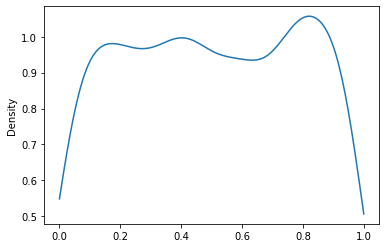

In [570]:
sns.kdeplot(bayesian_pvalue_test, clip=[0,1])

In [571]:
# Kolmogorov-Smirnov test to check
# null hypothesis of continuous uniform distribution
sp.stats.kstest(bayesian_pvalue_test, cdf=sp.stats.uniform.cdf)

KstestResult(statistic=0.02124999999999999, pvalue=0.7488325197424746)

### Test the function on an inaccurate model

In [256]:
ys_np_f = pm.Normal.dist(mu=0, sigma=3.).random
ys_np = np.array([ys_np_f() for _ in range(100)])

In [257]:
with pm.Model() as testmodel:
    ys = pm.Data('observed', ys_np)
    mu = pm.Normal('mu', mu=0, sigma=1)
    pm.Normal('ys', mu=mu, observed=ys)
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [258]:
with testmodel:
    pps_test = pm.fast_sample_posterior_predictive(trace)

In [259]:
pps_test = pps_test['ys']

In [260]:
bayesian_pvalue_test = calculate_bayesian_posterior_pvalue(
    trace, 
    pps_test, 
    testmodel,
    pointwise=True,
    # return_full=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 

<AxesSubplot:ylabel='Density'>

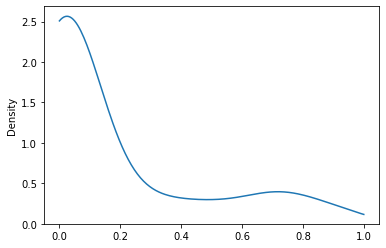

In [261]:
sns.kdeplot(bayesian_pvalue_test, clip=[0,1])

In [262]:
# Kolmogorov-Smirnov test to check
# null hypothesis of continuous uniform distribution
sp.stats.kstest(bayesian_pvalue_test, cdf=sp.stats.uniform.cdf)

KstestResult(statistic=0.587, pvalue=2.5812598874901702e-33)

## Parameter recovery

In [196]:
def parameter_recovery_MAP(model, nsamples, data):
    # Simulated datasets from the prior
    # Assuming that the prior is somewhat vague
    # this should give a good coverage of the parameter space
    with model:
        prior_pd = pm.sample_prior_predictive(nsamples)

    # Find the MAP of all parameters for each simulated dataset
    MAP_values = []
    for i, row in enumerate(prior_pd['utterances']):
        with model:
            pm.set_data({'observed': row})
            MAP_values.append(pm.find_MAP(progressbar=False))
        print(i, end=', ')
    pm.set_data({'observed': data.index_utterance}, model=model)
    return prior_pd, MAP_values


def plot_MAP_recovery(prior_pd, MAP_values, figsize=(7,3)):
    
    # get non transformed variable names
    variables = [
        k 
        for k in prior_pd.keys() 
        if not pm.util.is_transformed_name(k)
        if k != 'utterances'
    ]
    
    fig, axes = plt.subplots(1,len(variables), figsize=figsize)
    
    for ax, variable in zip(axes, variables):
        ax.scatter(
            prior_pd[variable], 
            [a[variable] for a in MAP_values]
        )
        ax.set_title(variable)

    axes[0].set_ylabel('MAP')
    # draw y=x line for each ax
    for ax in axes:
        ax.set_xlabel('real value')
        xpoints = ypoints = ax.get_xlim()
        ax.plot(
            xpoints, 
            ypoints, 
            linestyle='--', 
            color='k', 
            lw=1, 
            scalex=False, 
            scaley=False
        )

    plt.tight_layout()
    plt.show()

# Display and compare argstrengths

## Plotting functions

In [73]:
def calculate_arg_deltas(argumentative_strengths, possible_observations, possible_utterances):
    """
    Parameters
    ----------
    argumentative_strengths: array 
        see return value of calculate_argumentative_strengths
    possible_observations, possible_utterances: 2-d array
        See return values of get_and_clean_data function
    Returns
    -------
    array
        Difference in argument strength between 
        the chosen utterance and the most argstrong one
        possible given the observation
    """
    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])
    argstrengths_masked = np.where(
        utterance_observation_compatibility,
        argumentative_strengths[:,None],
        -np.inf
    )
    argdeltas = argstrengths_masked.max(0, keepdims=True) - argstrengths_masked
    return argdeltas
    
    
def calculate_info_deltas(possible_utterances, possible_observations):
    """
    Parameters
    ----------
    possible_utterances, possible_observations: arrays
        See return values of get_and_clean_data function
    Returns
    -------
    array
        Difference in informativeness between 
        the chosen utterance and the most informative one
        possible given the observation
    """
    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])
    p_observation_given_utterance = normalize(utterance_observation_compatibility,1)
    informativity = np.log(p_observation_given_utterance)
    infodeltas = informativity.max(0, keepdims=True) - informativity
    # infodeltas has shape (# utterances, # observations)
    return infodeltas

In [85]:
def plot_compare_argstrength_maximin(gamma_for, gamma_against,
                                     argumentative_strengths_positive, 
                                     argumentative_strengths_negative):
    
    # high condition
    maximin_argstrength_high = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_for, 
        gamma_against
    )
    
    # low condition
    maximin_argstrength_low = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_against, 
        gamma_for
    )
    df = pd.DataFrame(
        possible_utterances,
        columns=['q1', 'q2', 'adj']
    )

    df['minimax_high'] = maximin_argstrength_high
    df['minimax_low'] = maximin_argstrength_low
    df['minimax_delta'] = maximin_argstrength_high - maximin_argstrength_low

    df['bf_high'] = argumentative_strengths_positive
    df['bf_low'] = argumentative_strengths_negative

    df = df.sort_values('minimax_delta').reset_index(drop=True)
    df = df.drop(columns='minimax_delta',)

    # ax = df.plot(
    #     kind='barh', 
    #     # subplots=True, 
    #     yticks=np.arange(len(df)),
    #     # legend=False,
    #     figsize=(6,15),
    #     layout=(1,5),
    #     sharey=True
    # )
    
    ax = df.plot(
        kind='bar', 
        # subplots=True, 
        xticks=np.arange(len(df)),
        # legend=False,
        figsize=(15,6),
        layout=(5,1),
        sharex=True
    )

    # for ax in axes.flatten():
    # ax.set_yticklabels(df.iloc[:,:3].apply(lambda x: '|'.join(x), 1))
    ax.set_xticklabels(df.iloc[:,:3].apply(lambda x: '|'.join(x), 1))
    plt.xticks(rotation=75)

    plt.tight_layout()
    plt.show()

## Plots

### Plot lr-argstrengths

In [74]:
argumentative_strengths_positive = calculate_argumentative_strength(
    possible_utterances, possible_observations,
    0.85, 0.15
)

argumentative_strengths_negative = calculate_argumentative_strength(
    possible_utterances, possible_observations,
    0.15, 0.85
)

In [75]:
info_deltas = calculate_info_deltas(
    possible_utterances, 
    possible_observations
)

arg_deltas_negative = calculate_arg_deltas(
    argumentative_strengths_negative,
    possible_observations, 
    possible_utterances
)

arg_deltas_positive = calculate_arg_deltas(
    argumentative_strengths_positive,
    possible_observations, 
    possible_utterances
)

/tmp/ipykernel_5222/3783439829.py:47: RuntimeWarning: divide by zero encountered in log
  informativity = np.log(p_observation_given_utterance)


In [76]:
xlabels = [','.join(a) for a in possible_utterances]

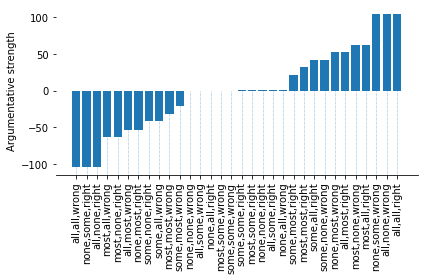

In [77]:
# calculate and plot the argumentative strengths
# for all possible signals, in the high condition
argumentative_strengths = calculate_argumentative_strength(
    possible_utterances, possible_observations,
    0.85, 0.15
)

fig, ax = plt.subplots()

argsort = np.argsort(argumentative_strengths)
ax.bar(np.arange(len(argumentative_strengths)), argumentative_strengths[argsort])
ax.set_xticks(range(len(argumentative_strengths)))
ax.set_xticklabels(np.array(xlabels)[argsort], rotation=90)
ax.set_ylabel(r'Argumentative strength')
# plt.show()

for x in ax.get_xticks():
    ax.axvline(
        x=x,
        ymax=0.5,
        ls=':',
        lw=0.5
    )

sns.despine(ax=ax, left=True)

fig.tight_layout()
fig.savefig('./figs/various/argstrengths.png', dpi=300)

In [78]:
argstrengths_array = np.array([
    calculate_argumentative_strength(
        possible_utterances, possible_observations,
        gamma, 1-gamma
    )
    for gamma 
    in np.linspace(0,1,1000)
])

/tmp/ipykernel_5222/345919538.py:153: RuntimeWarning: divide by zero encountered in log
  np.log(
/tmp/ipykernel_5222/345919538.py:161: RuntimeWarning: divide by zero encountered in log
  np.log(


Most of the signals have consistent ordering of argstrength across all values of $\gamma$ (flipped at 0.5, as expected). However, there's two signals that change ordering:

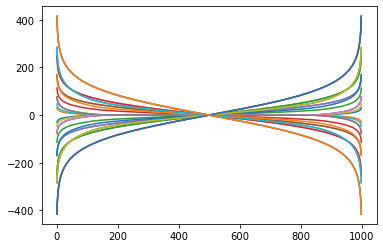

In [79]:
plt.plot(argstrengths_array)
plt.show()

### Plot $S_1$ with an lr-argstrength

/tmp/ipykernel_5222/278256974.py:101: RuntimeWarning: divide by zero encountered in log
  informativity = np.log(p_observation_given_utterance)


[3 3 0 0 0]


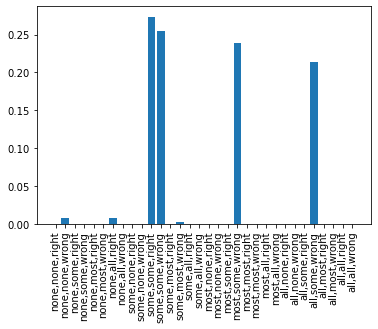

In [84]:
# calculate the probability of the pragmatic speaker 
# producing each utterance for a specific observation.

utterance_observation_compatibility = np.stack([
    verify(*a, possible_observations)
    for a in possible_utterances
])

p_observation_given_utterance = (
    utterance_observation_compatibility / 
    utterance_observation_compatibility.sum(0, keepdims=True)
)

p_utterance_given_observation = calculate_pragmatic_speaker(
    argumentative_strengths, 
    p_observation_given_utterance,
    costs=get_costs(possible_utterances), 
    alpha=1.1, 
    beta=0.8
)

index_observation = 17

print(possible_observations[index_observation])

fig, ax = plt.subplots()
ax.bar(
    np.arange(len(p_utterance_given_observation[:,index_observation])), 
    p_utterance_given_observation[:,index_observation]
)
ax.set_xticks(range(32))
ax.set_xticklabels(xlabels, rotation=90)
plt.show()

### Compare maximin and lr argstrengths

Compare the maximin-argstrength of all signals when arguing against the 'opposite' claim (e.g. 0.85, 0.15).

/tmp/ipykernel_5222/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


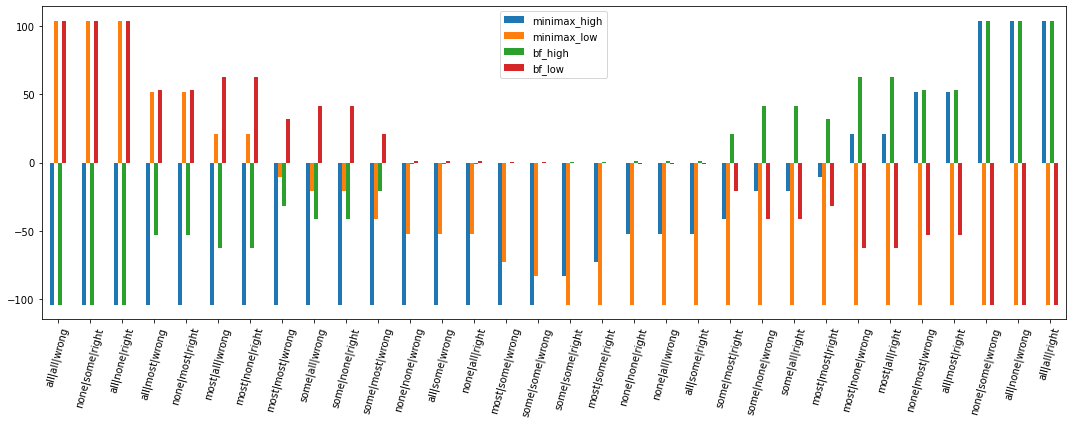

In [86]:
plot_compare_argstrength_maximin(
    0.85, 
    0.15,
    argumentative_strengths_positive, 
    argumentative_strengths_negative
)

Compare the maximin-argstrength of all signals when arguing against the 'neutral' claim (e.g. 0.9, 0.5).

/tmp/ipykernel_5222/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


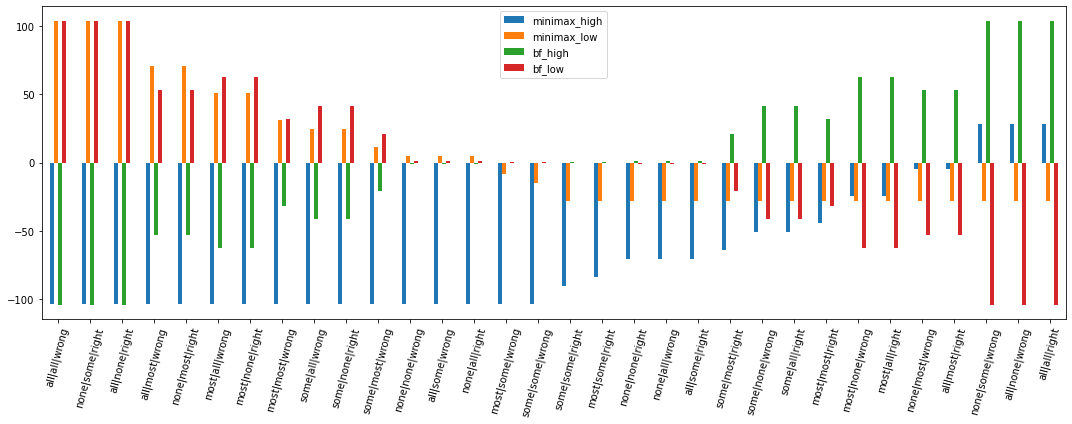

In [87]:
plot_compare_argstrength_maximin(
    0.9, 
    0.5,
    argumentative_strengths_positive, 
    argumentative_strengths_negative
)

### Check changes in the index of maximin obs depending on gamma

In [88]:
argmins = []
for gamma_prove in np.linspace(0.001,0.999,1000):
    
    gamma_disprove = 1-gamma_prove
    
    utterance_observation_compatibility = np.stack([
        functions.verify(*a, possible_observations)
        for a in possible_utterances
    ])
    utterance_observation_compatibility = np.where(
        utterance_observation_compatibility == 0,
        np.inf,
        utterance_observation_compatibility
    )
    
    # dimensions (utterances, observations)
    logp_for = np.log(calculate_p_obs_given_utterance_and_gamma_maximin(
        possible_observations, 
        utterance_observation_compatibility, 
        gamma_prove
    ))
    
    logp_against = np.log(calculate_p_obs_given_utterance_and_gamma_maximin(
        possible_observations, 
        utterance_observation_compatibility, 
        gamma_disprove
    ))
    
    # argmin finds the index of the observation that is argumentatively worst
    argmins.append(np.nanargmin(logp_for-logp_against, 1))
argmins = np.array(argmins)

/tmp/ipykernel_5222/1854795150.py:30: RuntimeWarning: invalid value encountered in subtract
  argmins.append(np.nanargmin(logp_for-logp_against, 1))


The plot makes it clear that there is a switch of the indices at 0.5 for most signals, and that's it, which actually makes sense, because that's where $\gamma$ goes from arguing for 'participants are good' to arguing for 'participants are bad'. 

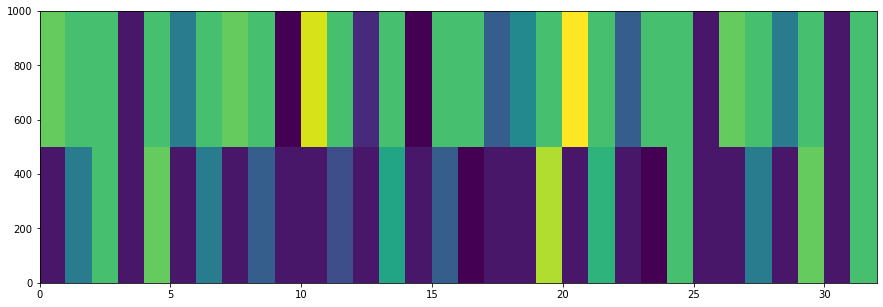

In [89]:
fig, ax = plt.subplots(figsize=(15,5))
ax.pcolor(argmins)

Question: What is, for each possible utterance, the observation considered by the minimax speaker to calculate the argstrength?

In [90]:
utt_arr = np.apply_along_axis(lambda x: '|'.join(x), 1, possible_utterances)

In [91]:
pd.DataFrame(
    np.column_stack((
        utt_arr,
        possible_observations[argmins[-1]]
    )),
)

0   1   2   3   4   5
0   none|none|right   3   3   3   3   3
1   none|none|wrong   0   0   0   0   0
2   none|some|right   0   0   0   0   0
3   none|some|wrong  12  12  12  12  12
4   none|most|right   0   0   0   0   0
5   none|most|wrong   9   9   9   9   9
6    none|all|right   0   0   0   0   0
7    none|all|wrong   3   3   3   3   3
8   some|none|right   0   0   0   0   0
9   some|none|wrong  12  12   0   0   0
10  some|some|right   3   3   0   0   0
11  some|some|wrong   0   0   0   0   0
12  some|most|right   9   9   0   0   0
13  some|most|wrong   0   0   0   0   0
14   some|all|right  12  12   0   0   0
15   some|all|wrong   0   0   0   0   0
16  most|none|right   0   0   0   0   0
17  most|none|wrong  12  12  12   0   0
18  most|some|right   3   3   3   0   0
19  most|some|wrong   0   0   0   0   0
20  most|most|right   9   9   9   0   0
21  most|most|wrong   0   0   0   0   0
22   most|all|right  12  12  12   0   0
23   most|all|wrong   0   0   0   0   0
24   all|none|right   0   0   0   0   0
25   all|none|wrong  12  12  12  12  12
26   all|some|right   3   3   3   3   3
27   all|some|wrong   0   0   0   0   0
28   all|most|right   9   9   9   9   9
29   all|most|wrong   0   0   0   0   0
30    all|all|right  12  12  12  12  12
31    all|all|wrong   0   0   0   0   0

### Plot maximin argstrength as a function of $\gamma$

In [92]:
acc_argstrengths = np.array([
    calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove, 
        1-gamma_prove
    )
    for gamma_prove 
    in np.linspace(0.001, 0.999, 1000)
])

/tmp/ipykernel_5222/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


Looks like all that $\gamma$ does (as long as it is kept in the 0.5 to 1. interval) is change how argumentatively strong a certain utterance is. This could mean that the $\beta$ parameter alone is sufficient.

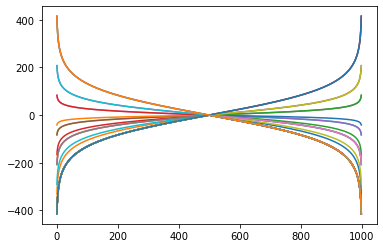

In [93]:
plt.plot(acc_argstrengths)
plt.show()

# The models

## Base RSA

### Completely pooled $\alpha$

(Originally called: `_lr_argstrength_noarg`)

In [142]:
def factory_model_base(data, possible_observations, possible_utterances, include_observed=True):
    
    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(utterance_observation_compatibility,1)
    costs = get_costs(possible_utterances)
                               
    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)
    
    with pm.Model() as model_base:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        p_utterance_given_observation = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
        )

        p_production = p_utterance_given_observation[
            :, 
            data.index_observation
        ]

        utterances = pm.Categorical(
            'utterances',
            p_production.T,
            observed=data_utterance if include_observed else None,
            shape=len(data['index_utterance'])
        )
    
    return model_base

### By-participant $\alpha$

(Originally called: `hierarchical_alpha_noconfusion_noarg`)

In [143]:
def factory_model_base_hierarchical(
        data, possible_observations, 
        possible_utterances, include_observed=True):
    
    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )
    costs = get_costs(possible_utterances)
                               
    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)
    
    with pm.Model() as model_base_hierarchical:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )
        
        alpha_mu = pm.Normal(
            'alpha_mu', 
            mu=0,
            sigma=5
        )
        alpha_sigma = pm.HalfNormal(
            'alpha_sigma',
            sigma=1
        )
        
        alpha = pm.TruncatedNormal(
            'alpha',
            mu=alpha_mu,
            sigma=alpha_sigma,
            lower=0,
            # number of participants
            shape=(data.id.max()+1,)
        )
        
        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        # dimensions (participant, utterance, observation)
        p_utterance_given_observation = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
        )
                        
        p_production = p_utterance_given_observation[
            data['id'],
            :, 
            data['index_observation']
        ]
        
        utterances = pm.Categorical(
            'utterances',
            p_production,
            observed=data_utterance if include_observed else None,
            shape=len(data)
        )
    
    return model_base_hierarchical

## Log-likelihood ratio argstrength RSA

### Completely pooled $\alpha$ and $\beta$

(Originally called: `_no_confusion`)

In [145]:
def factory_model_lr_argstrength(data, possible_observations, possible_utterances, 
                                 include_observed=True):
    
    argumentative_strengths_positive = calculate_argumentative_strength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.85, 
        gamma_disprove=0.15,
    )
    argumentative_strengths_negative = calculate_argumentative_strength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.15,
        gamma_disprove=0.85,
    )

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(utterance_observation_compatibility,1)
    costs = get_costs(possible_utterances)
                               
    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)
    
    with pm.Model() as model_lr_argstrength:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5
        )

        beta = pm.Uniform(
            'beta',
            lower=0,
            upper=1
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_positive
        )

        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_negative
        )

        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))

        p_production = p_utterance_given_observation[
            data.condition,
            :, 
            data.index_observation
        ]

        utterances = pm.Categorical(
            'utterances',
            p_production,
            observed=data_utterance if include_observed else None,
            shape=len(data['index_utterance'])
        )
    
    return model_lr_argstrength

### By-participant $\alpha$, $\beta$

In [144]:
def factory_model_lr_argstrength_hierarchical(data, possible_observations, 
                                              possible_utterances, include_observed=True):
    
    argumentative_strengths_positive = calculate_argumentative_strength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.85, 
        gamma_disprove=0.15,
    )
    argumentative_strengths_negative = calculate_argumentative_strength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.15,
        gamma_disprove=0.85,
    )

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )
    costs = get_costs(possible_utterances)

    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

    with pm.Model() as model_lr_argstrength_hierarchical:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )

        alpha_mu = pm.Normal(
            'alpha_mu', 
            mu=3,
            sigma=3
        )
        alpha_sigma = pm.HalfNormal(
            'alpha_sigma',
            sigma=1
        )
        
        alpha = pm.TruncatedNormal(
            'alpha',
            mu=alpha_mu,
            sigma=alpha_sigma,
            lower=0,
            # number of participants
            shape=(data.id.max()+1,)
        )

        # sample the hyperparameters
        # for the beta parameter
        beta_mu = pm.Normal(
            'beta_mu', 
            mu=0,
            sigma=1
        )
        beta_sigma = pm.HalfNormal(
            'beta_sigma',
            sigma=1
        ) 

        # condition_confusion_participant has length (# participants)
        # and contains the confusion probabilities particpant-wise
        beta_offset = pm.Normal(
            'beta_offset',
            # number of participants
            shape=(data.id.max()+1,)
        )
        beta = pm.Deterministic(
            'beta',
            pm.math.invlogit(beta_mu + beta_offset * beta_sigma)
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )
        
        costs = mask_none * cost

        # dims (participant, utterances, observations)
        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_positive
        )
        
        # dims (participant, utterances, observations)
        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_negative
        )
        
        # dims (condition, participant, utterance, observation)
        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))

        # dims (datapoint, utterance)
        p_production = p_utterance_given_observation[
            data['condition'],
            data['id'],
            :,
            data['index_observation']
        ]
        
        utterances = pm.Categorical(
            'utterances',
            p_production,
            observed=data_utterance if include_observed else None
        )
            
    return model_lr_argstrength_hierarchical

## Maximin argstrength RSA

### Completely pooled $\alpha$ and $\beta$

In [147]:
def factory_model_maximin_argstrength(data, possible_observations, 
                                      possible_utterances, include_observed=True):
    
    maximin_argstrengths_positive = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.85, 
        gamma_disprove=0.15
    )
    maximin_argstrengths_negative = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.15,
        gamma_disprove=0.85
    )

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(utterance_observation_compatibility,1)
    costs = get_costs(possible_utterances)
                               
    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)
    
    with pm.Model() as model_maximin_argstrength:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5
        )

        beta = pm.Uniform(
            'beta',
            lower=0,
            upper=1
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost
        
        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            maximin_argstrengths_positive
        )

        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            maximin_argstrengths_negative
        )

        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))

        p_production = p_utterance_given_observation[
            data.condition,
            :, 
            data.index_observation
        ]

        utterances = pm.Categorical(
            'utterances',
            p_production,
            observed=data_utterance if include_observed else None,
            shape=len(data['index_utterance'])
        )
    
    return model_maximin_argstrength

### By-participant $\alpha$, $\beta$

In [146]:
def factory_model_maximin_argstrength_hierarchical(data, possible_observations, 
                                                   possible_utterances, include_observed=True):
    
    argumentative_strengths_positive = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.85, 
        gamma_disprove=0.15
    )
    
    argumentative_strengths_negative = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.15, 
        gamma_disprove=0.85
    )

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )
    
    costs = get_costs(possible_utterances)

    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

    with pm.Model() as model_maximin_argstrength_hierarchical:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )

        alpha_mu = pm.Normal(
            'alpha_mu', 
            mu=0,
            sigma=5
        )
        alpha_sigma = pm.HalfNormal(
            'alpha_sigma',
            sigma=1
        )
        
        alpha = pm.TruncatedNormal(
            'alpha',
            mu=alpha_mu,
            sigma=alpha_sigma,
            lower=0,
            # number of participants
            shape=(data.id.max()+1,)
        )

        # sample the hyperparameters
        # for the beta parameter
        beta_mu = pm.Normal(
            'beta_mu', 
            mu=0,
            sigma=1
        )
        beta_sigma = pm.HalfNormal(
            'beta_sigma',
            sigma=1
        ) 

        # condition_confusion_participant has length (# participants)
        # and contains the confusion probabilities particpant-wise
        beta_offset = pm.Normal(
            'beta_offset',
            # number of participants
            shape=(data.id.max()+1,)
        )
        beta = pm.Deterministic(
            'beta',
            pm.math.invlogit(
                beta_mu + 
                beta_offset * beta_sigma
            )
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        # dims (participant, utterances, observations)
        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_positive
        )
        
        # dims (participant, utterances, observations)
        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_negative
        )
        
        # dims (condition, participant, utterance, observation)
        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))

        # dims (datapoint, utterance)
        p_production = p_utterance_given_observation[
            data['condition'],
            data['id'],
            :,
            data['index_observation']
        ]
        
        utterances = pm.Categorical(
            'utterances',
            p_production,
            observed=data_utterance if include_observed else None
        )
            
    return model_maximin_argstrength_hierarchical

## $S_1$ argstrength RSA

### Completely pooled $\alpha$ and $\beta$

In [108]:
def factory_model_prag_argstrength(data, possible_observations, 
                                   possible_utterances, include_observed=True):

    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )

    with pm.Model() as model_prag_argstrength:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5
        )

        beta = pm.Uniform(
            'beta',
            lower=0,
            upper=1
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        prag_argstrengths_positive = theano_calculate_pragmatic_argstrength(
            possible_utterances, 
            possible_observations,
            gamma_prove=0.85, 
            gamma_disprove=0.15,
            alpha=alpha,
            costs=costs,
            p_observation_given_utterance=p_observation_given_utterance
        )

        prag_argstrengths_negative = theano_calculate_pragmatic_argstrength(
            possible_utterances, 
            possible_observations,
            gamma_prove=0.15, 
            gamma_disprove=0.85,
            alpha=alpha,
            costs=costs,
            p_observation_given_utterance=p_observation_given_utterance
        )

        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            prag_argstrengths_positive
        )

        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            prag_argstrengths_negative
        )

        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))

        p_production = p_utterance_given_observation[
            data['condition'],
            :,
            data['index_observation']
        ]

        pm.Categorical(
            'utterances',
            p_production,
            observed=data_utterance
        )
    
    return model_prag_argstrength

### By-participant $\alpha$ and $\beta$

In [132]:
def factory_model_prag_argstrength_hierarchical(data, possible_observations, 
                                   possible_utterances, include_observed=True):

    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )

    with pm.Model() as model_prag_argstrength_hierarchical:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )

        alpha_mu = pm.Normal(
            'alpha_mu', 
            mu=0,
            sigma=5
        )
        alpha_sigma = pm.HalfNormal(
            'alpha_sigma',
            sigma=1
        )
        
        alpha = pm.TruncatedNormal(
            'alpha',
            mu=alpha_mu,
            sigma=alpha_sigma,
            lower=0,
            # number of participants
            shape=(data.id.max()+1,)
        )

        # sample the hyperparameters
        # for the beta parameter
        beta_mu = pm.Normal(
            'beta_mu', 
            mu=0,
            sigma=1
        )
        beta_sigma = pm.HalfNormal(
            'beta_sigma',
            sigma=1
        ) 

        # condition_confusion_participant has length (# participants)
        # and contains the confusion probabilities particpant-wise
        beta_offset = pm.Normal(
            'beta_offset',
            # number of participants
            shape=(data.id.max()+1,)
        )
        beta = pm.Deterministic(
            'beta',
            pm.math.invlogit(
                beta_mu + 
                beta_offset * beta_sigma
            )
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        prag_argstrengths_positive = theano_calculate_pragmatic_argstrength(
            possible_utterances, 
            possible_observations,
            gamma_prove=0.85, 
            gamma_disprove=0.15,
            alpha=alpha,
            costs=costs,
            p_observation_given_utterance=p_observation_given_utterance
        )

        prag_argstrengths_negative = theano_calculate_pragmatic_argstrength(
            possible_utterances, 
            possible_observations,
            gamma_prove=0.15, 
            gamma_disprove=0.85,
            alpha=alpha,
            costs=costs,
            p_observation_given_utterance=p_observation_given_utterance
        )
                
        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            prag_argstrengths_positive
        )

        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            prag_argstrengths_negative
        )

        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))
        
        p_production = p_utterance_given_observation[
            data['condition'],
            data['id'],
            :,
            data['index_observation']
        ]

        pm.Categorical(
            'utterances',
            p_production,
            observed=data_utterance if include_observed else None
        )
    
    return model_prag_argstrength_hierarchical

# Analysis of pilot data

## Get pilot data

In [22]:
raw_data, data, possible_observations, possible_utterances = get_and_clean_data()

a total of 200 of the raw datapoints are test trials. This leaves 20 potential datapoints per participant.
8  were excluded because incompletely recorded
88  were excluded because literally false


/mnt/c/Users/faust/Dropbox/Tubingen/argumentative_language/functions.py:162: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  str(len(data[raw_data['trial_name'] != 'main_trials'])) +


## Display pilot data

### Plot observation-wise argdeltas, infodeltas, and counts

Calculate the infodeltas and argdeltas, and the counts of
of utterances for each condition and observation combination.

In [1294]:
data['infodelta'] = info_deltas[data.index_utterance, data.index_observation]
arg_deltas = np.stack((arg_deltas_negative, arg_deltas_positive))
data['argdelta'] = arg_deltas[data.condition, data.index_utterance, data.index_observation]
data_copy = data.copy()
data_copy['row_number'] = data['row_number'].apply(lambda x: '|'.join([str(i) for i in x]))
data_copy['response'] = data['response'].apply(lambda x: '|'.join([str(i) for i in x]))

counts = data_copy.value_counts(
    ['row_number','condition', 'response', 'infodelta', 'argdelta']
).reset_index()

Display an example of counts for one observation in one condition.

In [1296]:
counts[
    (counts['row_number'] =='9|9|3|3|3') &
    (counts['condition'] == 0)
]

row_number  condition         response  infodelta   argdelta   0
21   9|9|3|3|3          0  most|most|wrong   0.000000   0.000000  17
57   9|9|3|3|3          0   all|some|wrong   0.000000  13.055311   5
79   9|9|3|3|3          0  some|most|wrong   0.470004  10.049935   3
127  9|9|3|3|3          0   none|all|right   0.000000  13.055311   1
142  9|9|3|3|3          0  some|some|right   0.641854  13.822535   1

Plot for each observation/condition some information about (counts of observed in data, argdelta, etc)

In [1300]:
%%capture
# NOTE: capture prevents the cell from printing output 

xs, ys = np.mgrid[0:5,0:12]

for i, obs in enumerate(possible_observations):    
    
    fig, axes = plt.subplots(2,2)
    
    str_obs = '|'.join([str(a) for a in obs])
        
    subset_low = counts[
        (counts['row_number'] == str_obs) &
        (counts['condition'] == 1)
    ][['response', 0, 'infodelta', 'argdelta']].reset_index(drop=True)
    
    subset_high = counts[
        (counts['row_number'] == str_obs) &
        (counts['condition'] == 0)
    ][['response', 0, 'infodelta', 'argdelta']].reset_index(drop=True)
            
    axes[0,0].axis('off')
    axes[0,0].axis('tight')
    axes[0,0].table(
        cellText=subset_high.values, 
        colLabels=subset_high.columns, 
        loc='center',
        edges='vertical'
    )
    axes[0,0].set_title(
        'Low condition',
        rotation='vertical',
        x=-0.1,
        y=0.5,
        fontsize=8,
        verticalalignment='center'
    )
        
    axes[0,1].axis('off')
    axes[0,1].axis('tight')
    axes[0,1].table(
        cellText=subset_low.values,
        colLabels=subset_low.columns, 
        loc='center',
        edges='vertical'
    )
    axes[0,1].set_title(
        'High condition',
        rotation='vertical',
        x=-0.1,
        y=0.5,
        fontsize=8,
        verticalalignment='center'
    )
    
    todraw = (ys <= np.array(obs)[:,None])
    axes[1,0].imshow(todraw)
    axes[1,0].set_yticks(np.arange(5))
    axes[1,0].set_yticklabels(['Lisanne', 'Mia', 'Julia', 'Theresa', 'Julian'])
    axes[1,0].set_xticks(np.arange(13))
    axes[1,0].set_xlabel(obs)
    
    axes[1,1].axis('off')
    axes[1,1].axis('tight')

    fig.savefig(f'figs/by_observation_argdelta/{i}.png', dpi=300, facecolor='white')
    plt.close(fig)

### More data plots

In [104]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, color, label, kwargs_scatter=dict(), kwargs_hist=dict()):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, color=color, label=label, **kwargs_scatter)
    ax_histx.hist(x, bins=30, density=True, color=color, **kwargs_hist)
    ax_histy.hist(y, bins=30, orientation='horizontal', density=True, color=color, **kwargs_hist)

In [127]:
#### Run this cell if you want to plot with maximin instead

argstrength_positive = calculate_maximin_argstrength(
    possible_utterances, 
    possible_observations, 
    0.85, 
    0.15
)

argstrength_negative = calculate_maximin_argstrength(
    possible_utterances, 
    possible_observations, 
    0.15, 
    0.85
)

arg_deltas_positive = calculate_arg_deltas(
    argstrength_positive,
    possible_observations,
    possible_utterances
)

arg_deltas_negative = calculate_arg_deltas(
    argstrength_negative,
    possible_observations,
    possible_utterances
)

<ipython-input-57-83fce6e5df13>:31: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


In [129]:
info_deltas_pointwise = info_deltas[data['index_utterance'], data['index_observation']]

arg_deltas_pointwise = np.where(
    data['condition'],
    arg_deltas_positive[data['index_utterance'], data['index_observation']],
    arg_deltas_negative[data['index_utterance'], data['index_observation']]
)

signal = [
    '|'.join(x)
    for x 
    in data['response']
]

obs = [
    '|'.join(np.array(x).astype(str))
    for x 
    in data['row_number']
]

df_plot = pd.DataFrame({
    'argdeltas': arg_deltas_pointwise,
    'infodeltas': info_deltas_pointwise,
    'obs': obs
})

a = np.where(
    data['condition'],
    arg_deltas_positive[:, data['index_observation']],
    arg_deltas_negative[:, data['index_observation']]
)

b = info_deltas[:, data['index_observation']]

possible_argdeltas = a.flatten()
possible_infodeltas = b.flatten()
possible_values = np.column_stack((possible_infodeltas, possible_argdeltas))
possible_values = possible_values[np.all(possible_values!=np.inf,1)]

Plot the marginal distribution of informativity and argstrength in the observed data compared to the possible productions.

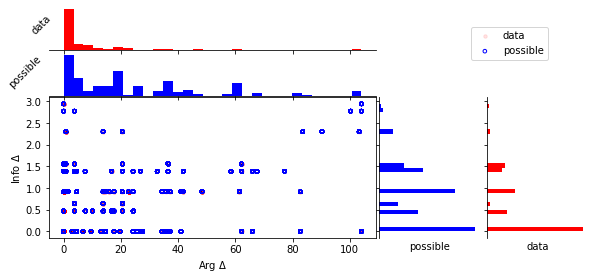

In [115]:
# start with a square Figure
fig = plt.figure(figsize=(7, 3))

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

rect_scatter = [left, bottom, width, height]
ax = fig.add_axes(rect_scatter)

ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# definitions for the axes
spacing = 0.22
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

ax_histx_1 = fig.add_axes(rect_histx, sharex=ax)
ax_histy_1 = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(
    x=arg_deltas_pointwise,
    y=info_deltas_pointwise,
    ax=ax, 
    ax_histx=ax_histx_1, 
    ax_histy=ax_histy_1,
    color='red',
    label='data',
    kwargs_scatter={
        'alpha': 0.1,
        's': 12
    }
)

scatter_hist(
    x=possible_values.T[1],
    y=possible_values.T[0],
    ax=ax, 
    ax_histx=ax_histx, 
    ax_histy=ax_histy,
    color='blue',
    label='possible',
    kwargs_scatter={
        'facecolor': 'none',
        'edgecolor': 'blue',
        's': 13
    }
)

ax.legend(
    bbox_to_anchor=(1.1, 1.1),
    bbox_transform=fig.transFigure
)

ax.set_xlabel(r'Arg $\Delta$')
ax.set_ylabel(r'Info $\Delta$')

sns.despine(ax=ax_histx, left=True)
sns.despine(ax=ax_histx_1, left=True)
ax_histx.set_yticks([])
ax_histx_1.set_yticks([])

sns.despine(ax=ax_histy, bottom=True)
sns.despine(ax=ax_histy_1, bottom=True)
ax_histy.set_xticks([])
ax_histy_1.set_xticks([])

ax_histy.set_xlabel('possible')
ax_histy_1.set_xlabel('data')

ax_histx.set_ylabel('possible', labelpad=20, rotation=45)
ax_histx_1.set_ylabel('data', rotation=45)

fig.savefig(
    'figs/various/distributionDeltas.png', 
    dpi=300, 
    bbox_inches="tight",
    transparent=False
)

Plot observed infodelta and argdelta for each student result array.

In [124]:
def plot_around_circle(ax_n, pos, g, letter):
    ax = g.axes[ax_n]
    ax.scatter(
        pos[0],
        pos[1],
        facecolors='none',
        edgecolors='fuchsia',
        s=30
    )
    ax.text(
        pos[0]-0.65,
        pos[1],
        s=letter,
        size=10,
        color='red'
    )

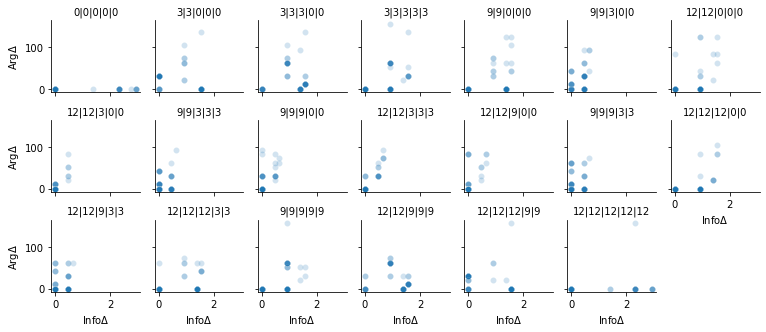

In [130]:
# with sns.plotting_context("paper"):
g = sns.FacetGrid(
    data=df_plot,
    col='obs',
    col_wrap=7,
    height=1.5,
    col_order=sorted(np.unique(obs), key=lambda x: np.array(x.split('|')).astype(int).sum())
)

g.map_dataframe(
    sns.scatterplot, 
    x="infodeltas", 
    y="argdeltas",
    alpha=0.2
)

g.set_titles(
    # row_template = '{row_name}', 
    col_template = '{col_name}'
)

g.set_xlabels(r'Info$\Delta$')
g.set_ylabels(r'Arg$\Delta$')
    
# 3|3|3|0|0
# plot_around_circle(
#     ax_n=2, 
#     pos=[0.916, 22.679], 
#     g=g,
#     letter='(a)'
# )

plt.savefig('figs/various/frontierobs.png', dpi=300)

### Plot participant-wise counts

It is convenient to have a surveyeable visualization of the data for each participant, especially below when I add hierarchical structure.

In [481]:
for i in np.unique(data['id'].values):
    participant_data = data[data['id']==i]
    part_data = participant_data['condition'].to_frame()
    part_data['response'] = participant_data['response'].apply(lambda x: '|'.join(x))
    part_data['obs'] = ['|'.join([str(a) for a in x]) for x in participant_data['row_number']]
    part_data['obs_sum'] = [np.array(x).sum() for x in participant_data['row_number']]
    part_data.reset_index(inplace=True, drop=True)
    part_data = part_data.sort_values(by=['condition', 'obs_sum']).reset_index(drop=True)
    part_data.drop(columns='obs_sum', inplace=True)
    pos_data = part_data[part_data['condition'] == 1].drop(columns='condition')
    neg_data = part_data[part_data['condition'] == 0].drop(columns='condition')
    
    fig, (ax_pos, ax_neg) = plt.subplots(1,2)
    ax_pos.axis('off')
    ax_pos.axis('tight')
    ax_pos.table(
        cellText=pos_data.values,
        colLabels=pos_data.columns, 
        loc='center',
        edges='vertical'
    )
    ax_pos.set_title('Positive condition')
    
    ax_neg.axis('off')
    ax_neg.axis('tight')
    ax_neg.table(
        cellText=neg_data.values,
        colLabels=neg_data.columns, 
        loc='center',
        edges='vertical'
    )
    ax_neg.set_title('Negative condition')
    
    fig.savefig(f'figs/by_participant/{i}.png', dpi=300)
    plt.close(fig)

### Plot participant-wise maximin argdelta and counts

In [1334]:
info_deltas = functions.calculate_info_deltas(
    possible_utterances, 
    possible_observations
)

maximin_argdeltas_negative = functions.calculate_arg_deltas(
    maximin_argstrength_low,
    possible_observations, 
    possible_utterances
)

maximin_argdeltas_positive = functions.calculate_arg_deltas(
    maximin_argstrength_high,
    possible_observations, 
    possible_utterances
)

/mnt/c/Users/faust/Dropbox/Tubingen/argumentative_language/functions.py:274: RuntimeWarning: divide by zero encountered in log
  verify(*a, possible_observations)


In [1335]:
data['infodelta'] = info_deltas[data.index_utterance, data.index_observation]
arg_deltas = np.stack((maximin_argdeltas_negative, maximin_argdeltas_positive))
data['maximin_argdelta'] = arg_deltas[data.condition, data.index_utterance, data.index_observation]
data_copy = data.copy()
data_copy['row_number'] = data['row_number'].apply(lambda x: '|'.join([str(i) for i in x]))
data_copy['response'] = data['response'].apply(lambda x: '|'.join([str(i) for i in x]))

counts = data_copy.value_counts(
    ['row_number','condition', 'response', 'infodelta', 'maximin_argdelta']
).reset_index()

In [1336]:
%%capture
# NOTE: capture prevents the cell from printing output 

xs, ys = np.mgrid[0:5,0:12]

for i, obs in enumerate(possible_observations):    
    
    fig, axes = plt.subplots(2,2)
    
    str_obs = '|'.join([str(a) for a in obs])
        
    subset_low = counts[
        (counts['row_number'] == str_obs) &
        (counts['condition'] == 1)
    ][['response', 0, 'infodelta', 'maximin_argdelta']].reset_index(drop=True)
    
    subset_high = counts[
        (counts['row_number'] == str_obs) &
        (counts['condition'] == 0)
    ][['response', 0, 'infodelta', 'maximin_argdelta']].reset_index(drop=True)
            
    axes[0,0].axis('off')
    axes[0,0].axis('tight')
    axes[0,0].table(
        cellText=subset_high.values, 
        colLabels=subset_high.columns, 
        loc='center',
        edges='vertical'
    )
    axes[0,0].set_title(
        'Low condition',
        rotation='vertical',
        x=-0.1,
        y=0.5,
        fontsize=8,
        verticalalignment='center'
    )
        
    axes[0,1].axis('off')
    axes[0,1].axis('tight')
    axes[0,1].table(
        cellText=subset_low.values,
        colLabels=subset_low.columns, 
        loc='center',
        edges='vertical'
    )
    axes[0,1].set_title(
        'High condition',
        rotation='vertical',
        x=-0.1,
        y=0.5,
        fontsize=8,
        verticalalignment='center'
    )
    
    todraw = (ys <= np.array(obs)[:,None])
    axes[1,0].imshow(todraw)
    axes[1,0].set_yticks(np.arange(5))
    axes[1,0].set_yticklabels(['Lisanne', 'Mia', 'Julia', 'Theresa', 'Julian'])
    axes[1,0].set_xticks(np.arange(13))
    axes[1,0].set_xlabel(obs)
    
    axes[1,1].axis('off')
    axes[1,1].axis('tight')

    fig.savefig(f'figs/by_observation_maximin_argdelta/{i}.png', dpi=300, facecolor='white')
    plt.close(fig)

## Parameter recovery for pooled models

We do parameter recovery assuming the same independent variable and number of participants as the observed pilot data.

For computational reasons we can only do parameter recovery with MAP. Since MAP is a particularly bad summary for hierarchical models, we only do parameter recovery for pooled models.

### Base RSA

In [197]:
prior_pd_base, recovered_base = parameter_recovery_MAP(model_base, 50, data)

# find the difference between the MAP parameters
# and the true parameters
differences_base = (
    pd.DataFrame({v:k for v,k in prior_pd_base.items() if v!='utterances'}) - 
    pd.DataFrame(recovered_base)
)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

<AxesSubplot:ylabel='Density'>

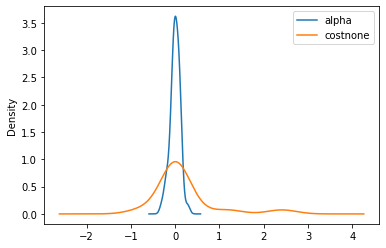

In [198]:
# plot the distribution of differences
differences_base[
    [k for k in differences_base.columns if not pm.util.is_transformed_name(k)]
].plot(kind='kde')

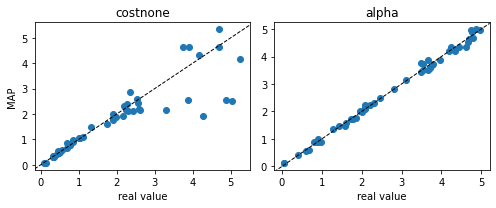

In [200]:
plot_MAP_recovery(prior_pd_base, recovered_base)

### Log-likelihood ratio argstrength RSA

In [210]:
prior_pd_lr_argstrength, recovered_lr_argstrength = parameter_recovery_MAP(
    model_lr_argstrength, 
    50, 
    data
)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

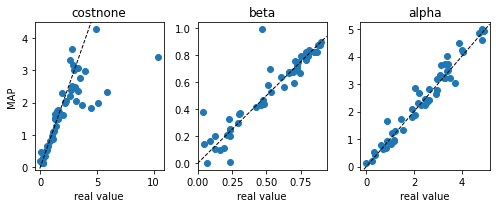

In [212]:
plot_MAP_recovery(prior_pd_lr_argstrength, recovered_lr_argstrength)

### Maximin argstrength RSA

In [213]:
prior_pd_maximin_argstrength, recovered_maximin_argstrength = parameter_recovery_MAP(
    model_maximin_argstrength, 
    50, 
    data
)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

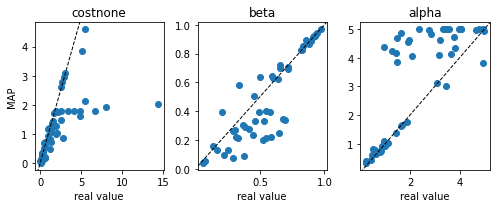

In [214]:
plot_MAP_recovery(prior_pd_maximin_argstrength, recovered_maximin_argstrength)

### $S_1$ argstrength RSA

In [215]:
prior_pd_prag_argstrength, recovered_prag_argstrength = parameter_recovery_MAP(
    model_prag_argstrength, 
    50, 
    data
)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

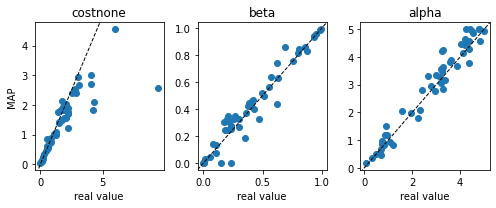

In [216]:
plot_MAP_recovery(prior_pd_prag_argstrength, recovered_prag_argstrength)

## Bayesian p-value

### Base RSA

#### Completely pooled $\alpha$

In [217]:
# Sample utterances in the same conditions
# as the experiment.
# Contains sampled utterances for each trial
# for each trace sample.
# Each row is a simulated experiment the array contains
# the index of the produced utterance in each trial
pps_base = pm.sample_posterior_predictive(
    trace_base,
    # samples=10000,
    model=model_base
)['utterances']

In [218]:
posterior_p_samples_base = calculate_bayesian_posterior_pvalue(
    trace_base, 
    pps_base, 
    model_base,
    # pointwise=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 

In [219]:
posterior_p_samples_base

0.49275

#### By-participant $\alpha$

In [220]:
pps_base_hierarchical = pm.sample_posterior_predictive(
    trace_base_hierarchical,
    # samples=10000,
    model=model_base_hierarchical
)['utterances']

In [222]:
posterior_p_samples_base_hierarchical = calculate_bayesian_posterior_pvalue(
    trace_base_hierarchical, 
    pps_base_hierarchical, 
    model_base_hierarchical,
    # pointwise=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 

In [223]:
posterior_p_samples_base_hierarchical

0.48475

### Log-likelihood ratio argstrength RSA

#### Completely pooled $\alpha$ and $\beta$

In [224]:
pps_lr_argstrength = pm.sample_posterior_predictive(
    trace_lr_argstrength,
    # samples=10000,
    model=model_lr_argstrength
)['utterances']

In [225]:
posterior_p_samples_lr_argstrength = calculate_bayesian_posterior_pvalue(
    trace_lr_argstrength, 
    pps_lr_argstrength, 
    model_lr_argstrength,
    # pointwise=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 

In [226]:
posterior_p_samples_lr_argstrength

0.4985

#### By-participant $\alpha$, $\beta$

In [227]:
pps_lr_argstrength_hierarchical = pm.sample_posterior_predictive(
    trace_lr_argstrength_hierarchical,
    # samples=10000,
    model=model_lr_argstrength_hierarchical
)['utterances']

In [230]:
posterior_p_samples_lr_argstrength_hierarchical = calculate_bayesian_posterior_pvalue(
    trace_lr_argstrength_hierarchical, 
    pps_lr_argstrength_hierarchical, 
    model_lr_argstrength_hierarchical,
    # pointwise=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 

In [231]:
posterior_p_samples_lr_argstrength_hierarchical

0.48375

### Maximin argstrength RSA

#### Completely pooled $\alpha$ and $\beta$

In [234]:
pps_maximin_argstrength = pm.sample_posterior_predictive(
    trace_maximin_argstrength,
    # samples=10000,
    model=model_maximin_argstrength
)['utterances']

In [235]:
posterior_p_samples_maximin_argstrength = calculate_bayesian_posterior_pvalue(
    trace_maximin_argstrength, 
    pps_maximin_argstrength, 
    model_maximin_argstrength,
    # pointwise=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 

In [236]:
posterior_p_samples_maximin_argstrength

0.49083333333333334

#### By-participant $\alpha$, $\beta$

In [237]:
pps_maximin_argstrength_hierarchical = pm.sample_posterior_predictive(
    trace_maximin_argstrength_hierarchical,
    # samples=10000,
    model=model_maximin_argstrength_hierarchical
)['utterances']

In [238]:
posterior_p_samples_maximin_argstrength_hierarchical = calculate_bayesian_posterior_pvalue(
    trace_maximin_argstrength_hierarchical, 
    pps_maximin_argstrength_hierarchical, 
    model_maximin_argstrength_hierarchical,
    # pointwise=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 

In [239]:
posterior_p_samples_maximin_argstrength_hierarchical

0.476375

### $S_1$ argstrength RSA

#### Completely pooled $\alpha$ and $\beta$

In [240]:
pps_prag_argstrength = pm.sample_posterior_predictive(
    trace_prag_argstrength,
    # samples=10000,
    model=model_prag_argstrength
)['utterances']

In [241]:
posterior_p_samples_prag_argstrength = calculate_bayesian_posterior_pvalue(
    trace_prag_argstrength, 
    pps_prag_argstrength, 
    model_prag_argstrength,
    # pointwise=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 

In [242]:
posterior_p_samples_prag_argstrength

0.5365

#### By-participant $\alpha$ and $\beta$

In [243]:
pps_prag_argstrength_hierarchical = pm.sample_posterior_predictive(
    trace_prag_argstrength_hierarchical,
    # samples=10000,
    model=model_prag_argstrength_hierarchical
)['utterances']

In [244]:
posterior_p_samples_prag_argstrength_hierarchical = calculate_bayesian_posterior_pvalue(
    trace_prag_argstrength_hierarchical, 
    pps_prag_argstrength_hierarchical, 
    model_prag_argstrength_hierarchical,
    # pointwise=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 

In [245]:
posterior_p_samples_prag_argstrength_hierarchical

0.5144166666666666

## Fit models

### Base RSA

#### Completely pooled $\alpha$

In [148]:
model_base = factory_model_base(
    data, 
    possible_observations, 
    possible_utterances
)

Defining non-hierarchical model


In [149]:
with model_base:
    trace_base = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [costnone, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


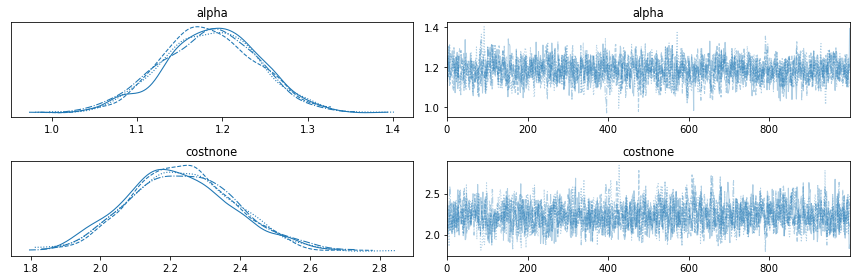

In [150]:
# run with argument strength calculated just using
# the possible observations in the experiment
az.plot_trace(trace_base)
plt.tight_layout()
plt.show()

In [151]:
save_trace(
    'base', 
    trace_base
)

#### By-participant $\alpha$

In [152]:
model_base_hierarchical = factory_model_base_hierarchical(
    data, 
    possible_observations, 
    possible_utterances
)

Defining hierarchical model


In [153]:
with model_base_hierarchical:
    trace_base_hierarchical = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [costnone, alpha, alpha_sigma, alpha_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 145 seconds.
The number of effective samples is smaller than 25% for some parameters.


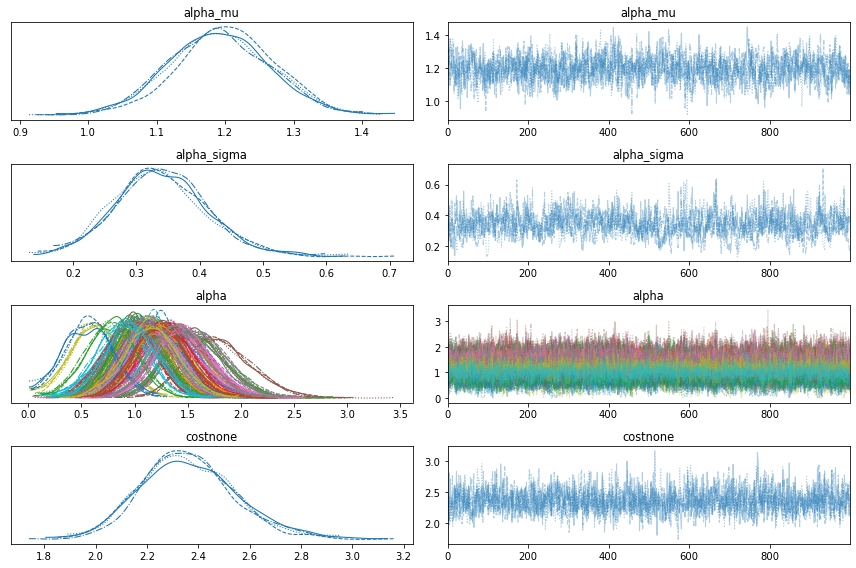

In [154]:
# run with argument strength calculated just using
# the possible observations in the experiment
az.plot_trace(trace_base_hierarchical)
plt.tight_layout()
plt.show()

In [155]:
save_trace(
    'base_hierarchical', 
    trace_base_hierarchical
)

### Log-likelihood ratio argstrength RSA

#### Completely pooled $\alpha$ and $\beta$

In [156]:
model_lr_argstrength = factory_model_lr_argstrength(
    data, 
    possible_observations, 
    possible_utterances
)

Defining non-hierarchical model
Defining non-hierarchical model


In [157]:
with model_lr_argstrength:
    trace_lr_argstrength = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [costnone, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
The number of effective samples is smaller than 25% for some parameters.


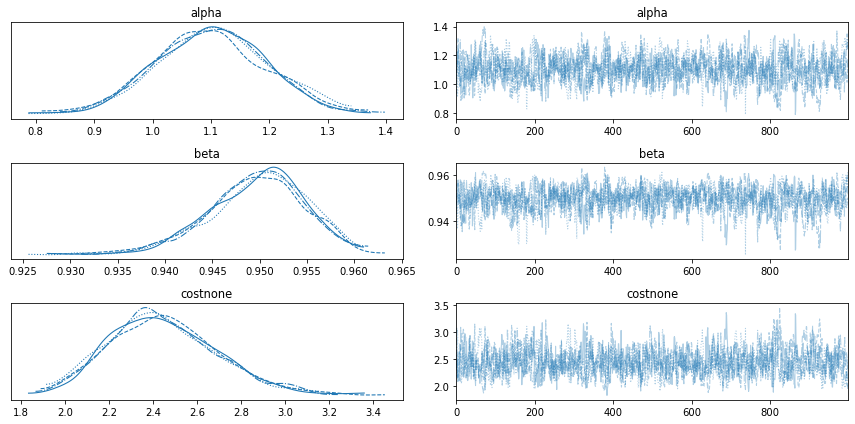

In [158]:
# run with argument strength calculated just using
# the possible observations in the experiment
az.plot_trace(trace_lr_argstrength)
plt.tight_layout()
plt.show()

In [159]:
save_trace(
    'lr_argstrength', 
    trace_lr_argstrength
)

#### By-participant $\alpha$, $\beta$

In [169]:
model_lr_argstrength_hierarchical = factory_model_lr_argstrength_hierarchical(
    data, 
    possible_observations, 
    possible_utterances
)

Defining hierarchical model
Defining hierarchical model


In [170]:
with model_lr_argstrength_hierarchical:
    trace_lr_argstrength_hierarchical = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.99,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [costnone, beta_offset, beta_sigma, beta_mu, alpha, alpha_sigma, alpha_mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1343 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


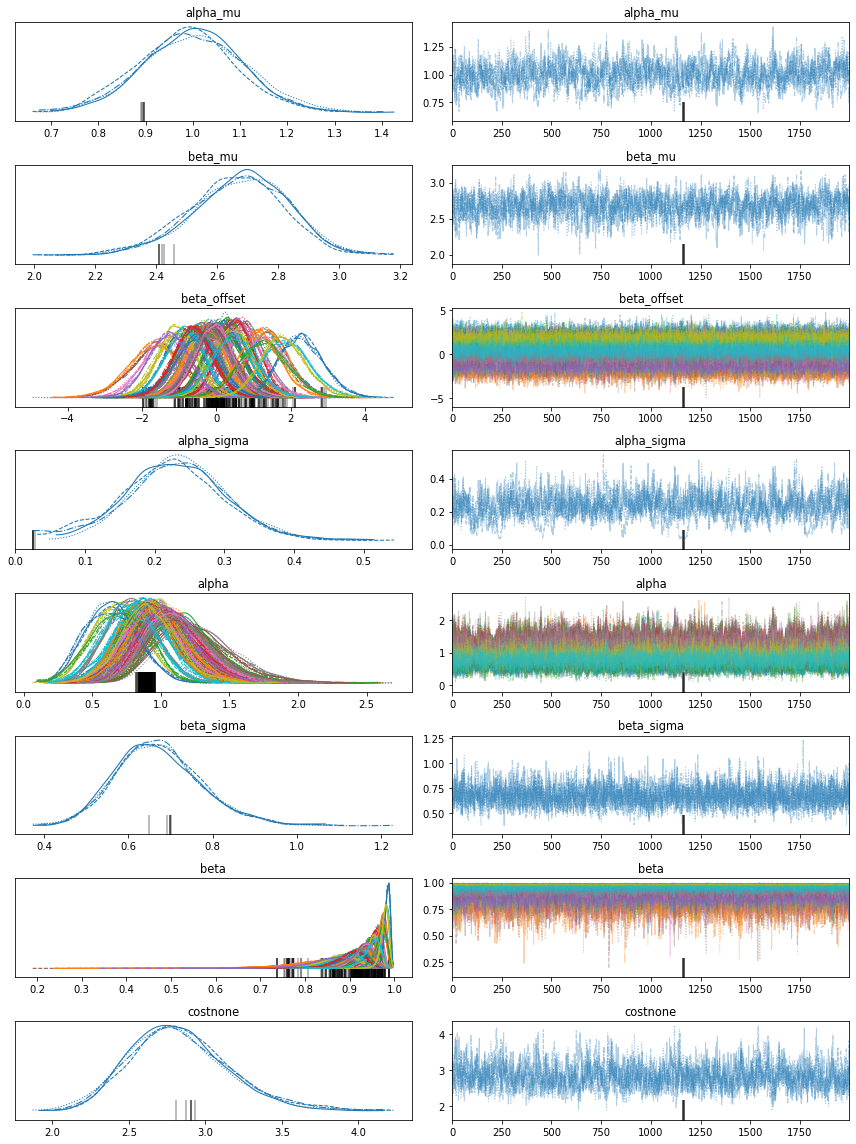

In [171]:
az.plot_trace(trace_lr_argstrength_hierarchical)
plt.tight_layout()
plt.show()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

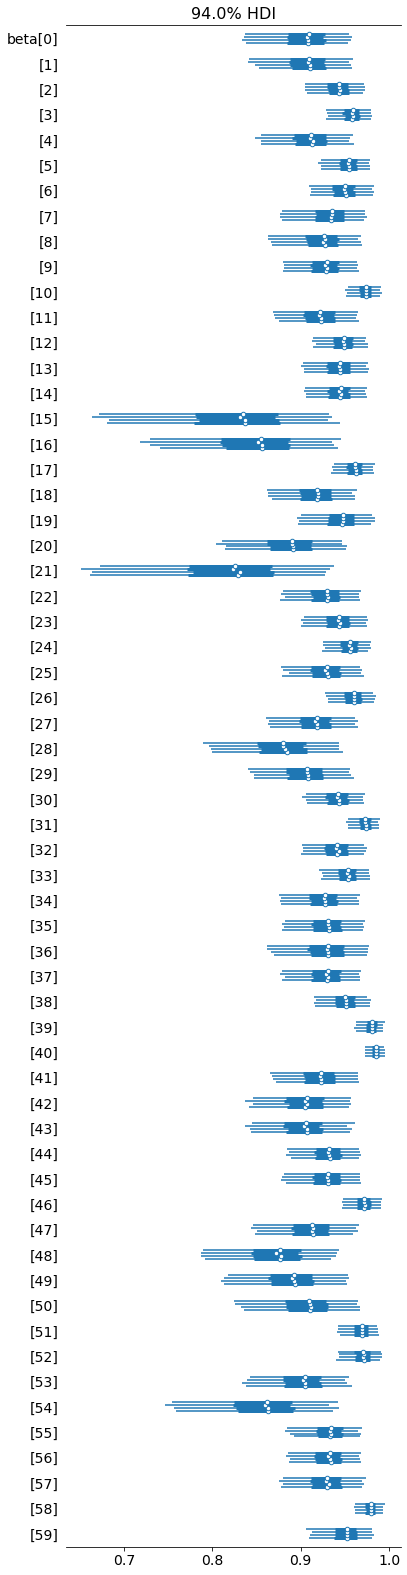

In [172]:
az.plot_forest(
    trace_lr_argstrength_hierarchical, 
    var_names=['beta']
)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

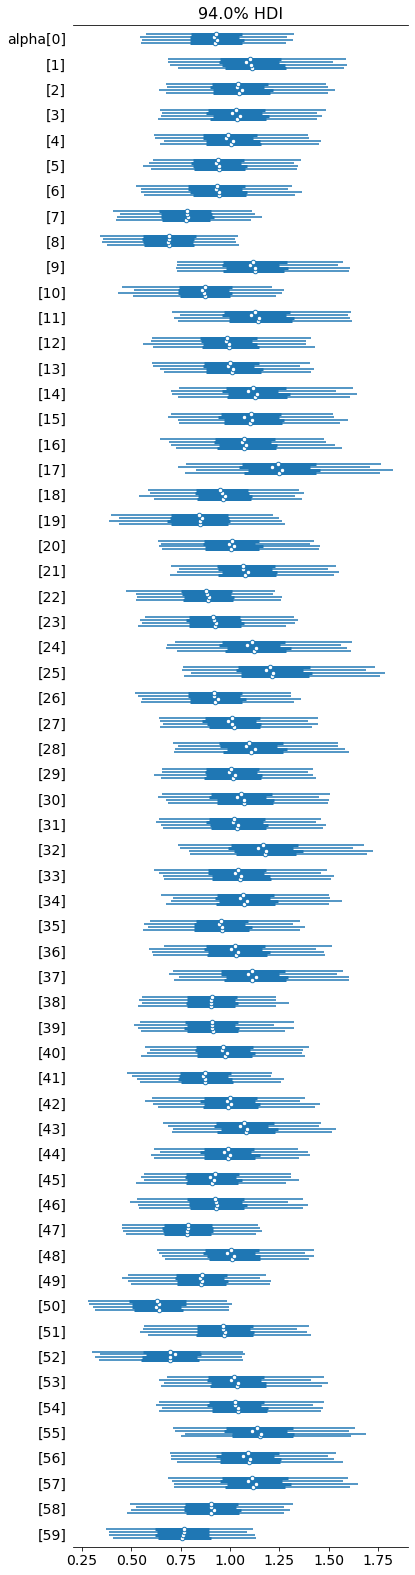

In [173]:
az.plot_forest(
    trace_lr_argstrength_hierarchical, 
    var_names=['alpha']
)

In [174]:
save_trace(
    'lr_argstrength_hierarchical', 
    trace_lr_argstrength_hierarchical
)

### Maximin argstrength RSA

#### Completely pooled $\alpha$ and $\beta$

In [175]:
model_maximin_argstrength = factory_model_maximin_argstrength(
    data, 
    possible_observations, 
    possible_utterances
)

/tmp/ipykernel_5222/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


Defining non-hierarchical model
Defining non-hierarchical model


In [176]:
with model_maximin_argstrength:
    trace_maximin_argstrength = pm.sample(
        draws=3000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [costnone, beta, alpha]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 235 seconds.
The number of effective samples is smaller than 25% for some parameters.


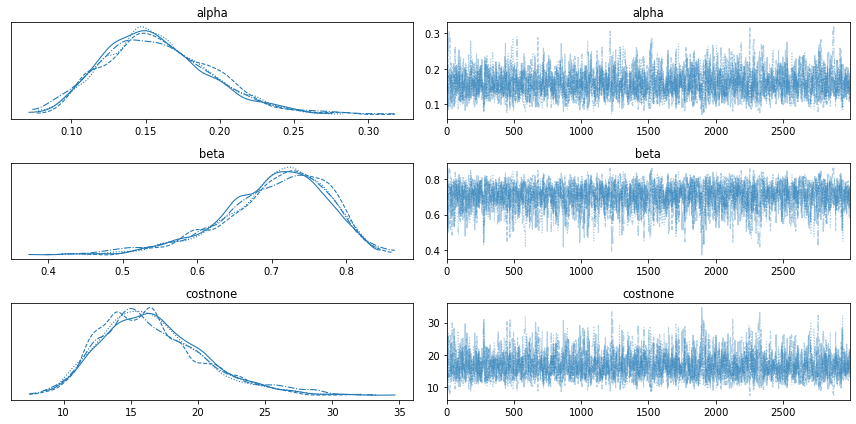

In [177]:
# run with argument strength calculated just using
# the possible observations in the experiment
az.plot_trace(trace_maximin_argstrength)
plt.tight_layout()
plt.show()

In [178]:
save_trace(
    'maximin_argstrength', 
    trace_maximin_argstrength
)

#### By-participant $\alpha$, $\beta$

In [179]:
model_maximin_argstrength_hierarchical = factory_model_maximin_argstrength_hierarchical(
    data, 
    possible_observations, 
    possible_utterances
)

/tmp/ipykernel_5222/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


Defining hierarchical model
Defining hierarchical model


In [180]:
with model_maximin_argstrength_hierarchical:
    trace_maximin_argstrength_hierarchical = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.99,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [costnone, beta_offset, beta_sigma, beta_mu, alpha, alpha_sigma, alpha_mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3616 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.961924088665315, but should be close to 0.99. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


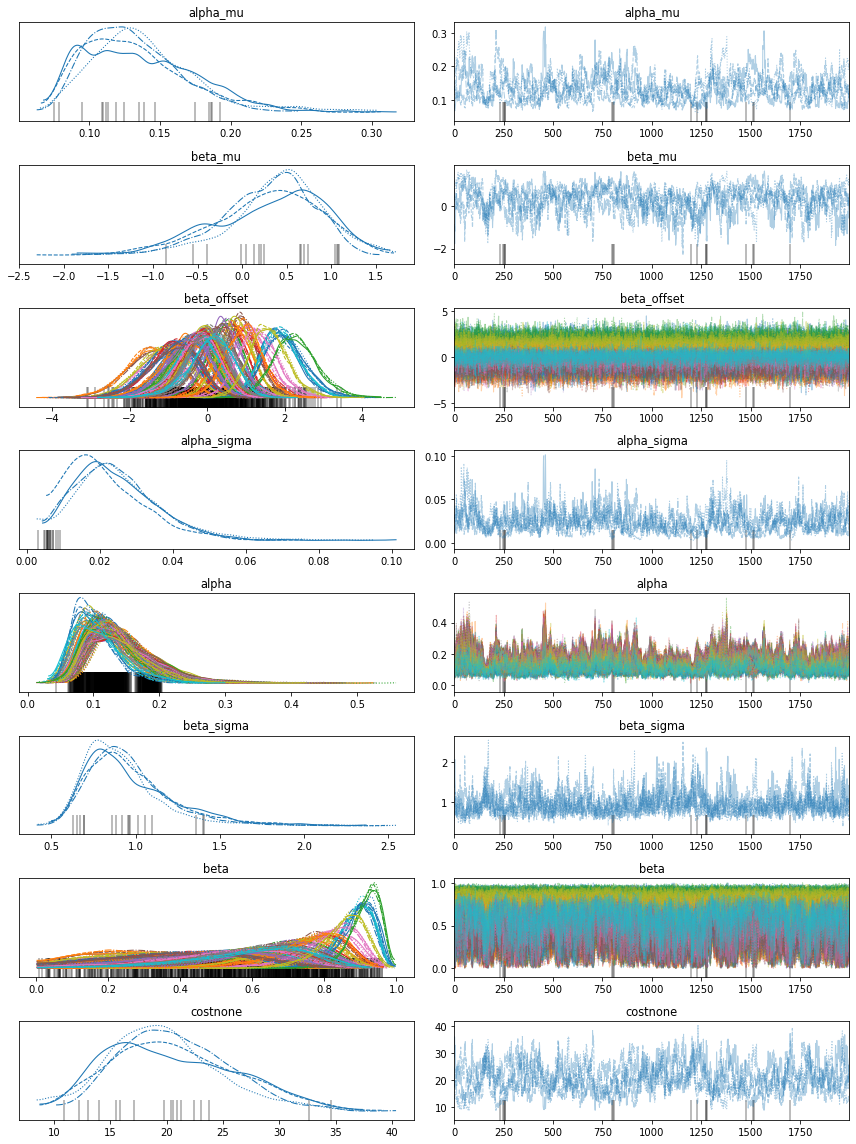

In [181]:
az.plot_trace(trace_maximin_argstrength_hierarchical)
plt.tight_layout()
plt.show()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

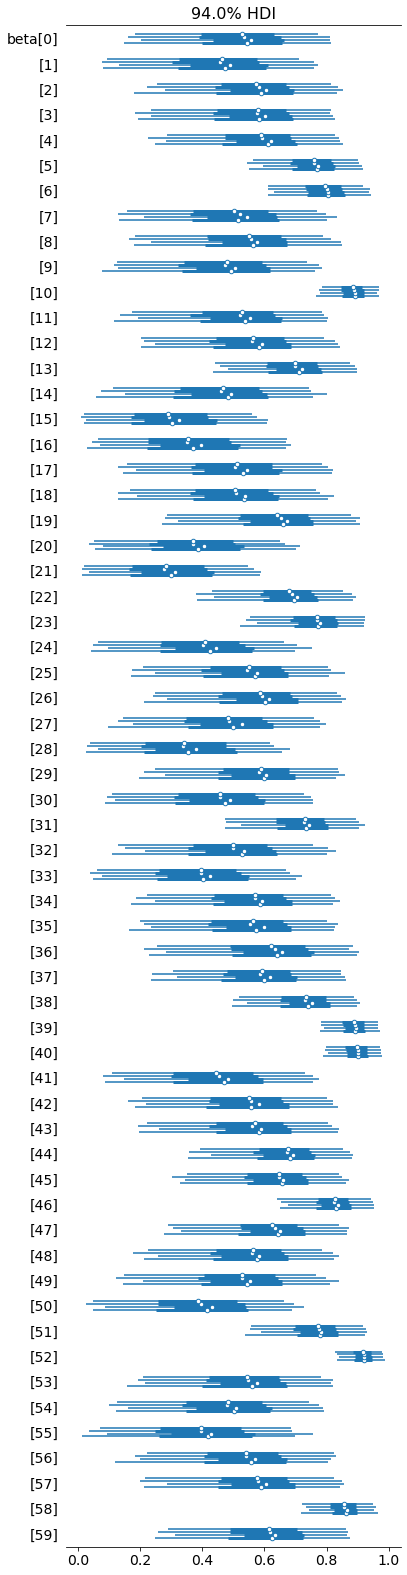

In [182]:
az.plot_forest(
    trace_maximin_argstrength_hierarchical, 
    var_names=['beta']
)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

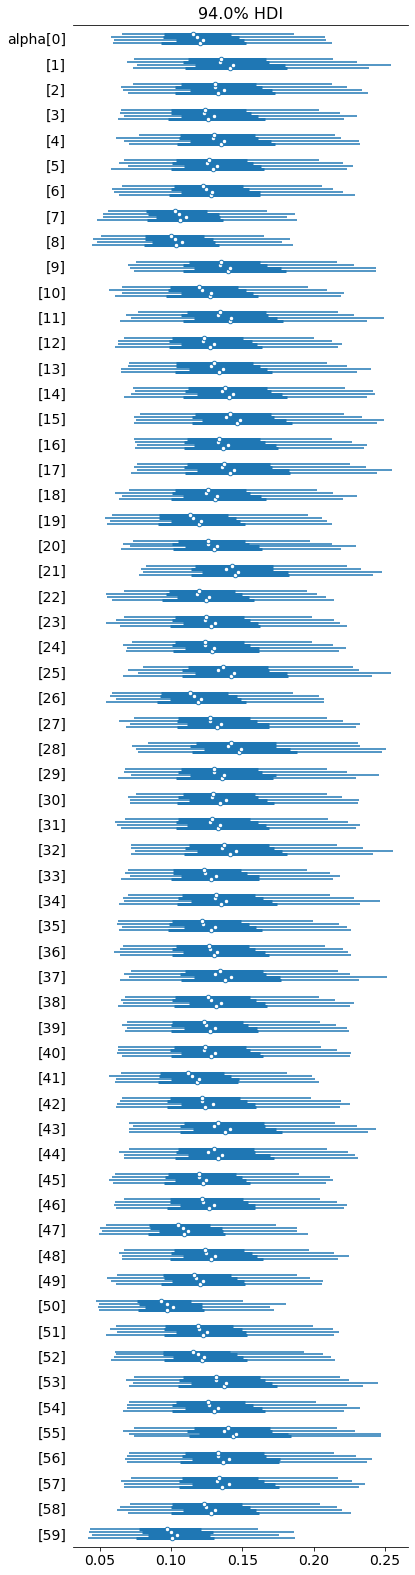

In [183]:
az.plot_forest(
    trace_maximin_argstrength_hierarchical, 
    var_names=['alpha']
)

In [184]:
save_trace(
    'maximin_argstrength_hierarchical', 
    trace_maximin_argstrength_hierarchical
)

### $S_1$ argstrength

#### Completely pooled $\alpha$ and $\beta$

In [138]:
model_prag_argstrength = factory_model_prag_argstrength(
    data, 
    possible_observations, 
    possible_utterances
)

Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


In [139]:
with model_prag_argstrength:
    trace_prag_argstrength = pm.sample(
        draws=3000,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [costnone, beta, alpha]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 165 seconds.
The number of effective samples is smaller than 25% for some parameters.


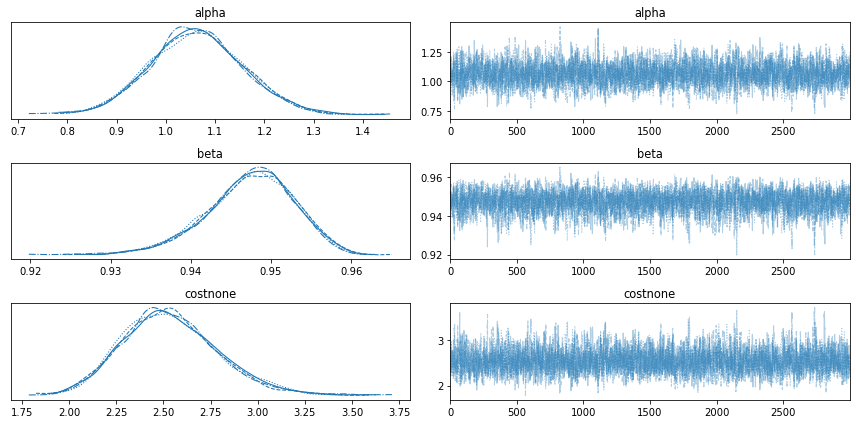

In [140]:
az.plot_trace(trace_prag_argstrength)
plt.tight_layout()

In [939]:
save_model_and_trace(
    'prag_argstrength', 
    trace_prag_argstrength
)

#### By-participant $\alpha$ and $\beta$

In [133]:
model_prag_argstrength_hierarchical = factory_model_prag_argstrength_hierarchical(
    data, 
    possible_observations, 
    possible_utterances
)

Defining hierarchical model
Defining hierarchical model
Defining hierarchical model
Defining hierarchical model


In [134]:
with model_prag_argstrength_hierarchical:
    trace_prag_argstrength_hierarchical = pm.sample(
        draws=3000,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True
    )

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [costnone, beta_offset, beta_sigma, beta_mu, alpha, alpha_sigma, alpha_mu]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 1163 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


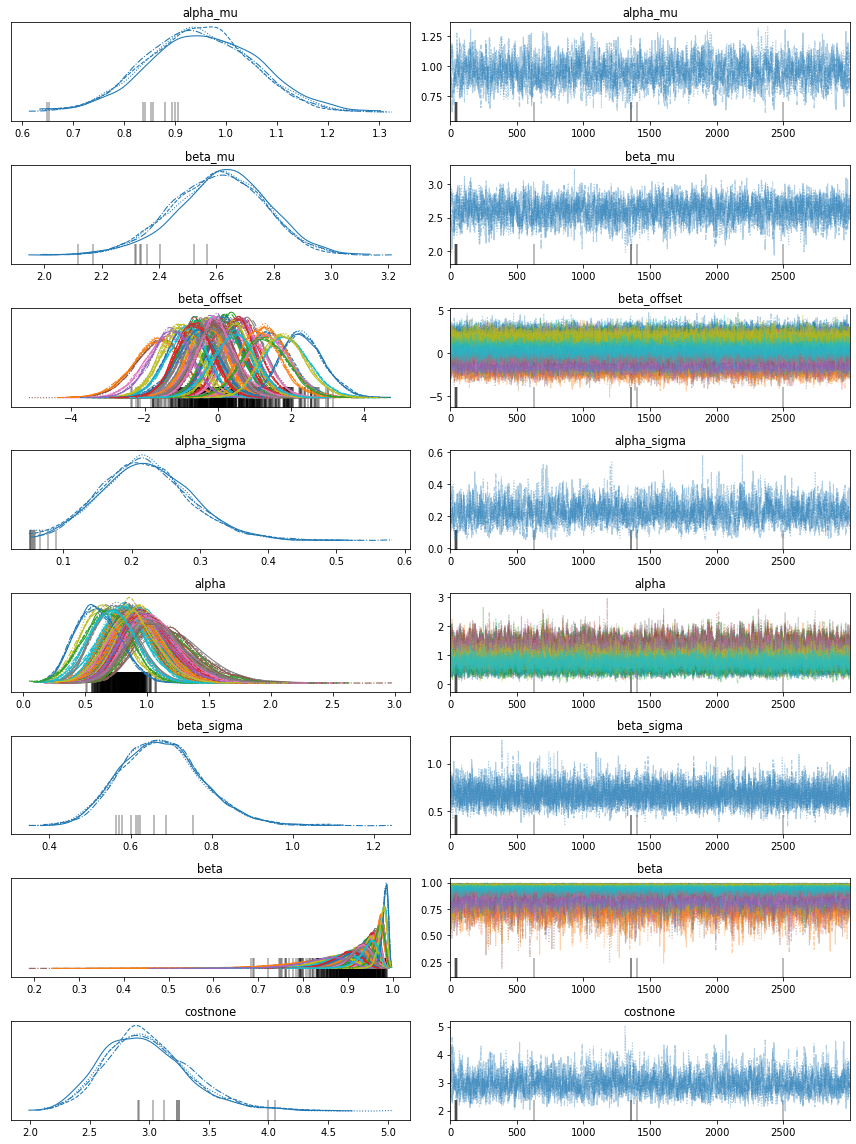

In [135]:
az.plot_trace(trace_prag_argstrength_hierarchical)
plt.tight_layout()

In [137]:
save_trace(
    'prag_argstrength_hierarchical', 
    trace_prag_argstrength_hierarchical
)

## Model comparison

### Pooled models

In [193]:
loo_comparison_pooled = az.compare(
    {
        'base': trace_base,
        'lr argstrength': trace_lr_argstrength,
        'maximin argstrength': trace_maximin_argstrength,
        'prag argstrength': trace_prag_argstrength
    }
)

<AxesSubplot:xlabel='Log'>

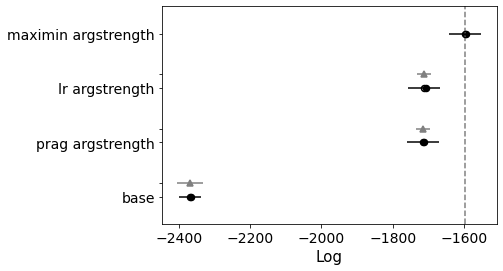

In [189]:
az.plot_compare(loo_comparison_pooled)

In [190]:
loo_comparison_pooled

rank          loo     p_loo       d_loo        weight  \
maximin argstrength     0 -1596.250535  2.625680    0.000000  8.554257e-01   
lr argstrength          1 -1711.720155  4.478396  115.469620  1.158359e-01   
prag argstrength        2 -1715.455147  4.343307  119.204612  6.937024e-16   
base                    3 -2369.281321  2.243422  773.030786  2.873840e-02   

                            se        dse  warning loo_scale  
maximin argstrength  45.374202   0.000000    False       log  
lr argstrength       45.497479  19.037004    False       log  
prag argstrength     45.490631  19.359618    False       log  
base                 30.449610  36.086387    False       log

### Hierarchical models

In [ ]:
loo_comparison_hierarchical = az.compare(
    {
        'base hierarchical': trace_base_hierarchical,
        'lr argstrength hierarchical': trace_lr_argstrength_hierarchical,
        'maximin argstrength hierarchical': trace_maximin_argstrength_hierarchical,
        'prag argstrength hierarchical': trace_prag_argstrength_hierarchical
    }
)

<AxesSubplot:xlabel='Log'>

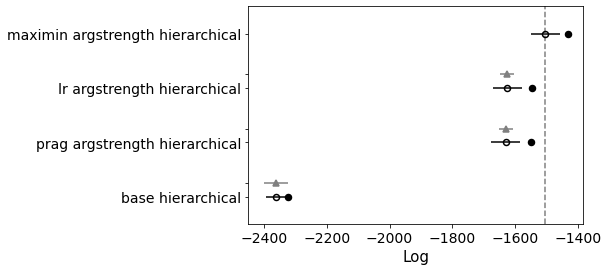

In [191]:
az.plot_compare(loo_comparison_hierarchical)

In [192]:
loo_comparison_hierarchical

rank          loo      p_loo       d_loo  \
maximin argstrength hierarchical     0 -1503.831228  72.596172    0.000000   
lr argstrength hierarchical          1 -1625.371556  80.137743  121.540328   
prag argstrength hierarchical        2 -1630.278260  81.313022  126.447033   
base hierarchical                    3 -2362.169684  38.604788  858.338456   

                                    weight         se        dse  warning  \
maximin argstrength hierarchical  0.803199  45.868700   0.000000     True   
lr argstrength hierarchical       0.174700  46.289836  22.064726     True   
prag argstrength hierarchical     0.000000  46.407743  22.333066     True   
base hierarchical                 0.022101  30.609377  38.995308    False   

                                 loo_scale  
maximin argstrength hierarchical       log  
lr argstrength hierarchical            log  
prag argstrength hierarchical          log  
base hierarchical                      log

# Analysis of experiment

TODO when the data is gathered!